In [1]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import math
import numpy as np
import seaborn as sns
import scipy.io as sio
import random
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Load Data

In [2]:
#read data for "covertype" data
#names=["Elevation","Aspect","Slope","Horizontal_Distance_To_Hydrology",
#                                        "Vertical_Distance_To_Hydrology",
#                                        "Horizontal_Distance_To_Roadways",
#                                        "Hillshade_9am","Hillshade_Noon",
#                                       "Hillshade_3pm",
#                                       "Horizontal_Distance_To_Fire_Points"]
covDF = pd.read_csv("covtype.csv")



In [3]:
#read data for "adult" data
#adultDF = pd.read_csv("adult.csv",names=["age","workclass", "fnlwgt","education","education-num","marital-status"
        #                                ,"occupation","relationship","race","sex","captial-gain"
         #                               ,"captial-loss", "hours-per-week","native-country"])



#read data for "online news" data
newsDF = pd.read_csv("OnlineNewsPopularity.csv")

#read data for "credit card" data
cardDF = pd.read_csv("default of credit card clients.csv")

#read data for "drug" data
#drugDF_train = pd.read_csv("drugsComTrain_raw.tsv", delimiter="\t")
#drugDF_test = pd.read_csv("drugsComTest_raw.tsv", delimiter="\t")

print(covDF.shape,newsDF.shape,cardDF.shape)

((581011, 55), (39644, 61), (30001, 25))


NOTES:

COVDF - all numerical, should be good to go if we are predicting the class
newsDF - remove first two columns because they aren't predictive values, target is number of shares
drugDF - remove first column because it is unknown what it means.
cardDF - change headers to the second line, predicting default payment

## Cleaning the data

- covDF needs to change target values. The class of Lodgepole Pine will be treated as positive while the rest will be treated as negative (based off of the Caruana paper). Last column will be used as target values
- newsDF needs to remove any columns that aren't repredictive. Target values will be the number of shares. Positive values will be shares greater than 1000, else negative
- cardDF needs to change the headers to ones that are more sensible. Target values will be yes or no to default payment

In [5]:
#cleaning newsDF
newsDF = newsDF.drop(columns=["url"," timedelta"])
newsDF[newsDF.iloc[:,58] < 1000] = 0
newsDF[newsDF.iloc[:,58] >= 1000] = 1

In [6]:
#cleaning cardDF
new_header = cardDF.iloc[0]
cardDF = cardDF[1:]
cardDF = cardDF.rename(columns = new_header)


In [7]:
#cleaning covDF

#change all 2's into postiive and all other values to negative
covDF = covDF.replace([1,3,4,5,6,7],0)
covDF = covDF.replace([2],1)


## Classifying data

- 3 partitions will be used: 80/20, 50/50, 20/80
- classifiers to be used: Boosting, Random Forest, Decision Tree
- cross validate and find accuracies

In [8]:
#Heat map function taken from previous homeworks in this class
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    

In [10]:
#cell to intialize classifiers average classifiers
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

In [11]:
def newsDF_classifer(newsDF,train_split,test_split,adaBoost_avg,randForest_avg,DecisionTree_avg):
    
    # train/test Split
    train_split = train_split
    test_split  = test_split
    X_vals = newsDF.iloc[:,0:57]
    Y_vals = newsDF.iloc[:,58]

    #randomize rows
    temp_x = X_vals.sample(frac=1).reset_index(drop = True)
    temp_Y = Y_vals.sample(frac=1).reset_index(drop = True)

    #For testing Purpose, get smaller size of 5000 samples
    temp_x = temp_x.head(10000)
    temp_Y = temp_Y.head(10000)

    #separate into training and test sets
    split = int(train_split * len(temp_x))
    X_train = temp_x.iloc[:split, :]           # Get features from train + val set.
    X_test  = temp_x.iloc[split:, :]           # Get features from test set.     
    Y_train = temp_Y.iloc[: split]             # Get labels from train + val set.
    Y_test  = temp_Y.iloc[split :]             # Get labels from test set.


    #train Adaboost classifier
    Ada_clf = AdaBoostClassifier()
    Ada_clf.fit(X_train,Y_train)

    print("Adaboost Classifier")
    print("Split -- %f Training, %f Testing") % (train_split, test_split)
    print("Train Accuracy : ", Ada_clf.score(X_train,Y_train))
    print("Test Accuracy: ", Ada_clf.score(X_test,Y_test))
    print("\n")

    #perform cross validation and gridsearch to get best parameters
    parameters = {"n_estimators": [50,100,200]}
    grid_cv = GridSearchCV(Ada_clf, parameters, return_train_score = 'true' )
    grid_cv.fit(X_train,Y_train)
    print(grid_cv.best_estimator_)

    #get average accuracies
    train_acc = grid_cv.cv_results_['mean_train_score']
    val_acc = grid_cv.cv_results_['mean_test_score']

    #print heat maps
    draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', [50,100,200] )
    draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', [50,100,200])

    #print best hyper-parameter(s)
    print("Best number of estimators: ", grid_cv.best_params_["n_estimators"])

    #store test accuracy
    adaBoost_avg = adaBoost_avg + grid_cv.score(X_test,Y_test)
    
    #Test Accuracy with best hyper-parameter
    print("Test Accuracy with best hyper-parameter: " , grid_cv.score(X_test,Y_test))

    print("\n###########################################################################\n")

    #train Random Forest classifier
    rand_forest_clf = RandomForestClassifier()
    rand_forest_clf.fit(X_train,Y_train)

    print("Random Forest Classifier")
    print("Split -- %f Training, %f Testing") % (train_split, test_split)
    print("Train Accuracy : ", rand_forest_clf.score(X_train,Y_train))
    print("Test Accuracy: ", rand_forest_clf.score(X_test,Y_test))
    print("\n")

    #perform cross validation and gridsearch to get best parameters
    parameters = {"n_estimators": [10,100,200],"max_depth":[2,4,6],"min_samples_split": [50,100,200]
                 , "min_samples_leaf": [1,2,4]}

    grid_cv = GridSearchCV(rand_forest_clf, parameters, return_train_score = 'true' )
    grid_cv.fit(X_train,Y_train)
    print(grid_cv.best_estimator_)

    #get average accuracies
    train_acc = grid_cv.cv_results_['mean_train_score']
    val_acc = grid_cv.cv_results_['mean_test_score']

    #print heat maps
    draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', [10,100,200] )
    draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', [10,100,200])

    #print best hyper-parameter(s)
    print("Best number of estimators: ", grid_cv.best_params_["n_estimators"])
    print("Best Max Depth: ", grid_cv.best_params_["max_depth"])

    #store test accuracy
    randForest_avg = randForest_avg + grid_cv.score(X_test,Y_test)
    
    #Test Accuracy with best hyper-parameter
    print("Test Accuracy with best hyper-parameter: " , grid_cv.score(X_test,Y_test))

    print("\n###########################################################################\n")

    #train SVM classifier
    DT_clf = DecisionTreeClassifier()
    DT_clf.fit(X_train,Y_train)

    print("Decision Tree Classifier")
    print("Split -- %f Training, %f Testing") % (train_split, test_split)
    print("Train Accuracy : ", DT_clf.score(X_train,Y_train))
    print("Test Accuracy: ", DT_clf.score(X_test,Y_test))
    print("\n")

    #perform cross validation and gridsearch to get best parameters
    parameters = {"max_depth":[1,2,3,4,5]}
    grid_cv = GridSearchCV(DT_clf, parameters, return_train_score = 'true' )
    grid_cv.fit(X_train,Y_train)
    print(grid_cv.best_estimator_)

    #get average accuracies
    train_acc = grid_cv.cv_results_['mean_train_score']
    val_acc = grid_cv.cv_results_['mean_test_score']

    #print heat maps
    draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', [1,2,3,4,5] )
    draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', [1,2,3,4,5])

    #print best hyper-parameter(s)
    print("Best Max_Depth: ", grid_cv.best_params_["max_depth"])

    #store test accuracy
    DecisionTree_avg = DecisionTree_avg + grid_cv.score(X_test,Y_test)
    
    #Test Accuracy with best hyper-parameter
    print("Test Accuracy with best hyper-parameter(s): " , grid_cv.score(X_test,Y_test))
    
    return adaBoost_avg,randForest_avg,DecisionTree_avg

NewsDF (80/20)
----------------------------

Trial #1
Adaboost Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.7115)
('Test Accuracy: ', 0.7235)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


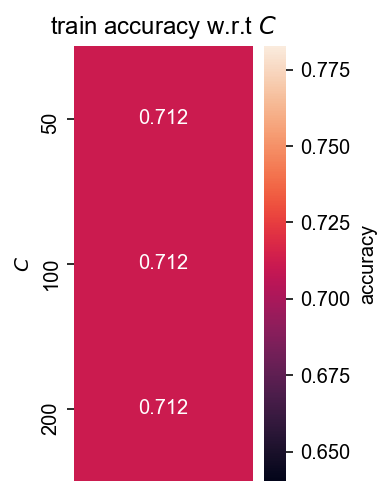

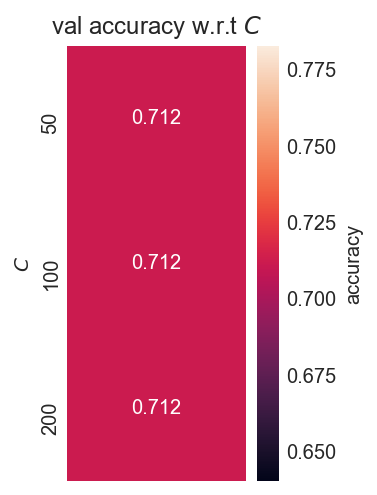

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7235)

###########################################################################

Random Forest Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.7115)
('Test Accuracy: ', 0.7235)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


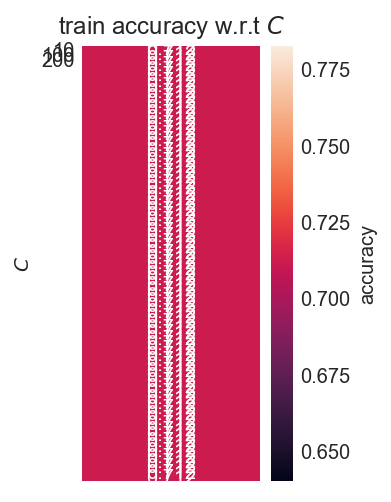

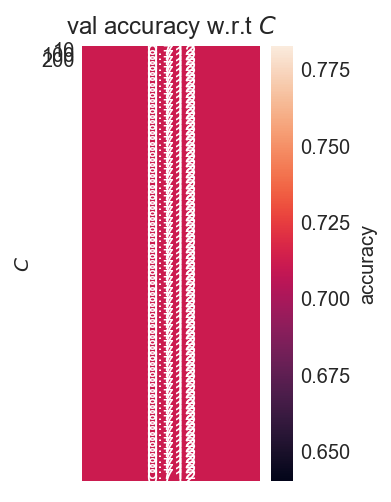

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.7235)

###########################################################################

Decision Tree Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.7115)
('Test Accuracy: ', 0.7235)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


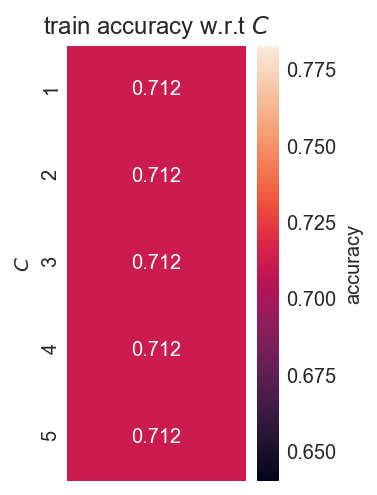

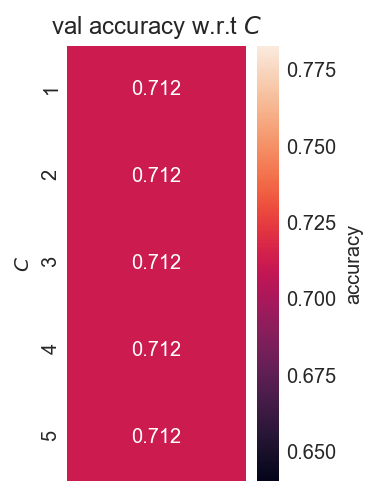

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.7235)

Trial #2
Adaboost Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.716375)
('Test Accuracy: ', 0.715)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


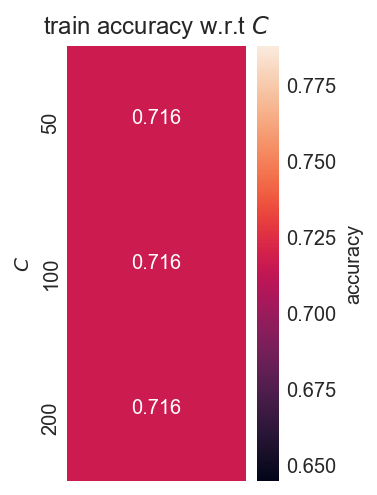

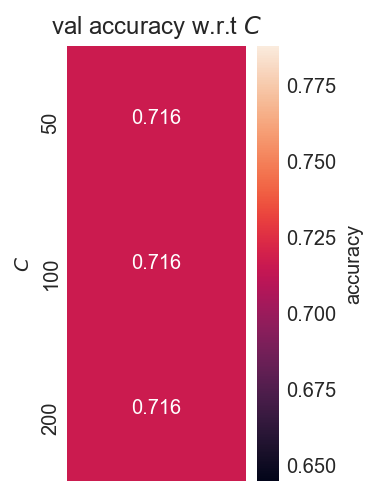

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.715)

###########################################################################

Random Forest Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.716375)
('Test Accuracy: ', 0.715)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


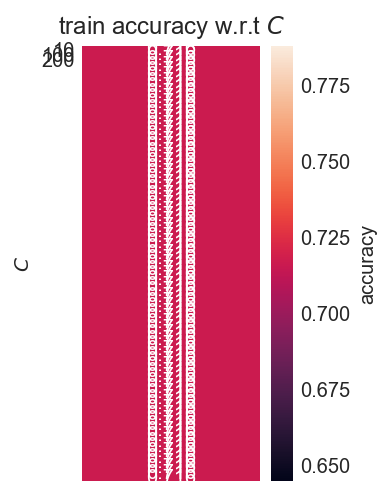

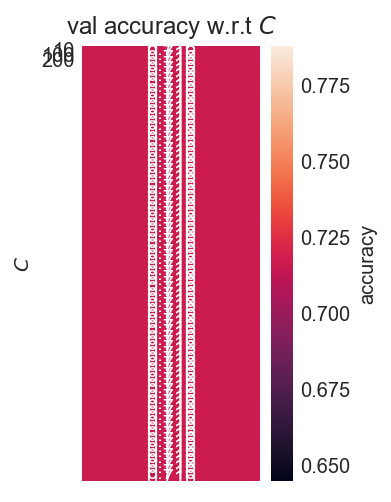

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.715)

###########################################################################

Decision Tree Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.716375)
('Test Accuracy: ', 0.715)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


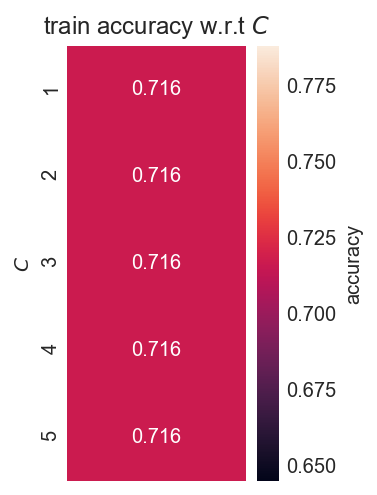

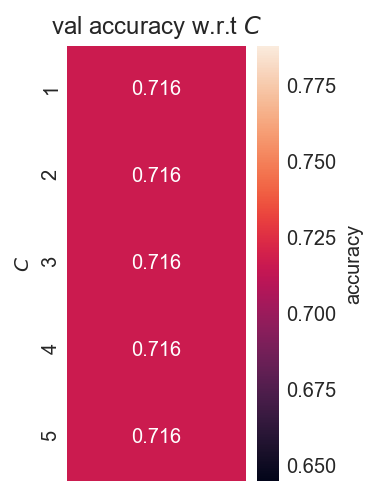

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.715)

Trial #3
Adaboost Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.717)
('Test Accuracy: ', 0.721)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


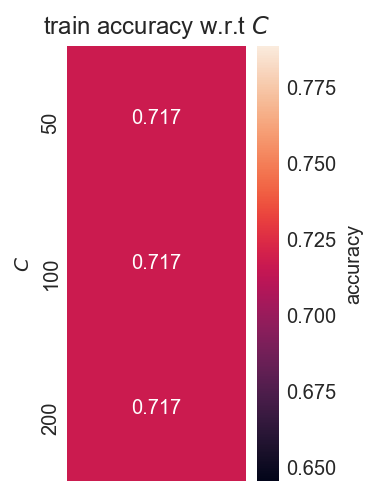

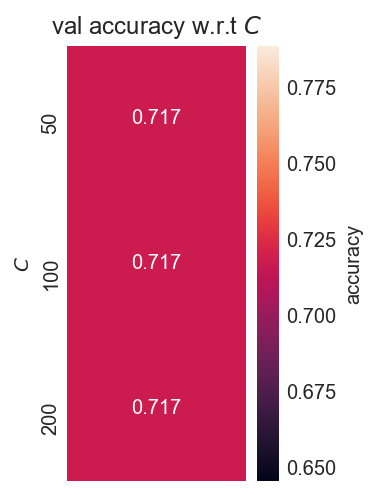

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.721)

###########################################################################

Random Forest Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.717)
('Test Accuracy: ', 0.721)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


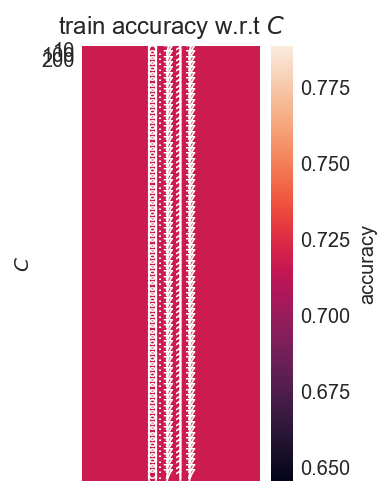

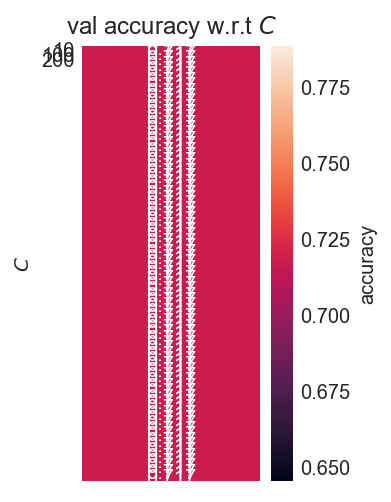

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.721)

###########################################################################

Decision Tree Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.717)
('Test Accuracy: ', 0.721)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


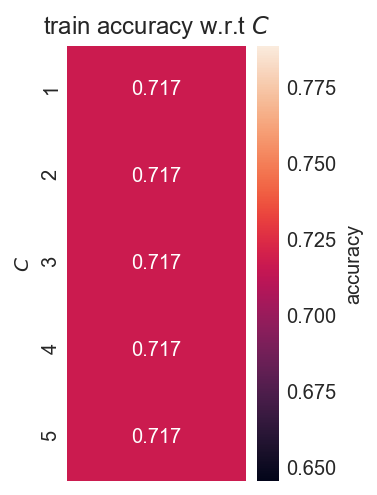

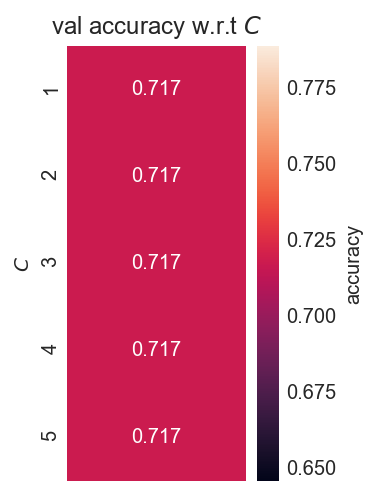

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.721)


In [12]:
#cell to call functions
print("NewsDF (80/20)")
print("----------------------------")
for num in range(0,3):
    
    print(("\nTrial #%d") % (num+1))
    adaBoost_avg,randForest_avg,DecisionTree_avg = newsDF_classifer(newsDF,.80,.20,adaBoost_avg,randForest_avg,DecisionTree_avg)

In [13]:
print(("Avg test error for Adaboost      (80/20): %f") % (float(adaBoost_avg / 3)))
print(("Avg test error for Random Forest (80/20): %f") % (float(randForest_avg / 3)))
print(("Avg test error for Decision Tree (80/20): %f") % (float(DecisionTree_avg / 3)))

#clear variables
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

Avg test error for Adaboost      (80/20): 0.719833
Avg test error for Random Forest (80/20): 0.719833
Avg test error for Decision Tree (80/20): 0.719833


NewsDF (50/50)
----------------------------

Trial #1
Adaboost Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7144)
('Test Accuracy: ', 0.7194)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


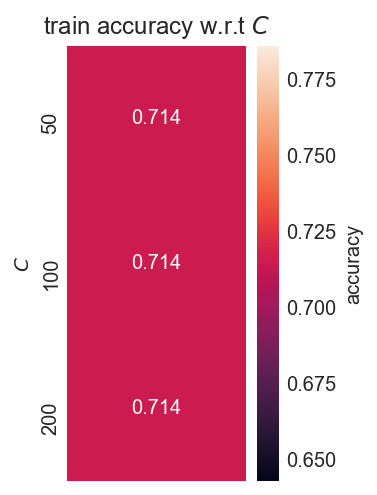

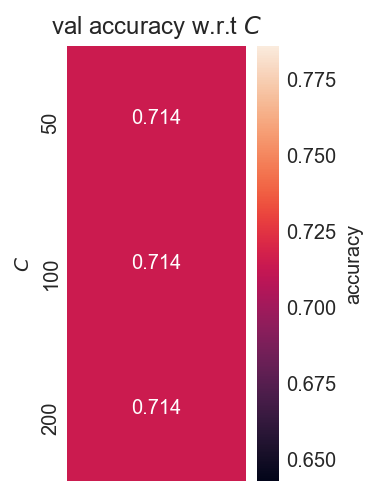

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7194)

###########################################################################

Random Forest Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7144)
('Test Accuracy: ', 0.7194)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


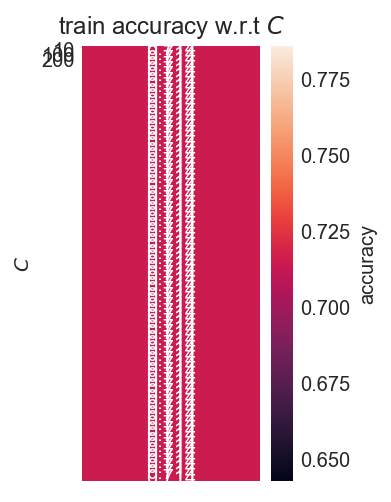

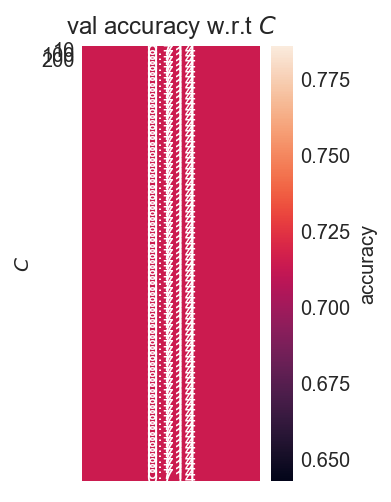

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.7194)

###########################################################################

Decision Tree Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7144)
('Test Accuracy: ', 0.7194)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


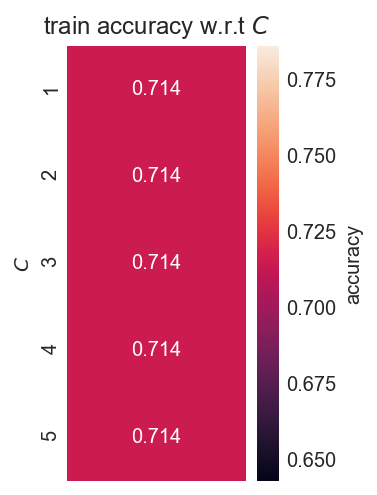

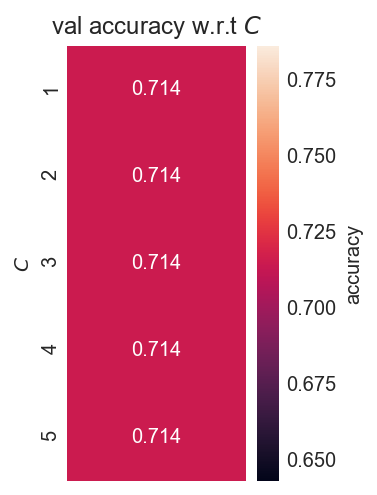

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.7194)

Trial #2
Adaboost Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7134)
('Test Accuracy: ', 0.7126)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


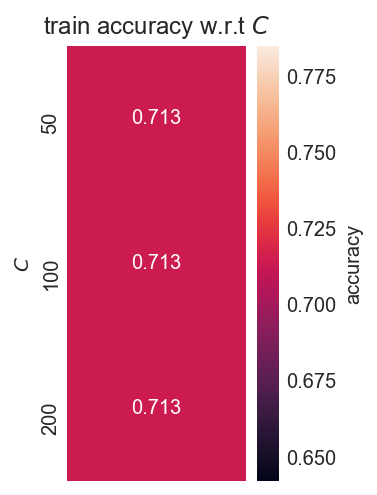

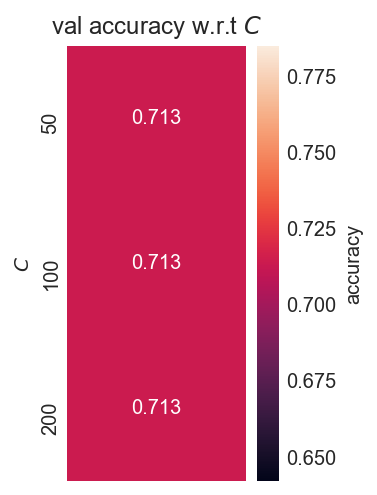

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7126)

###########################################################################

Random Forest Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7134)
('Test Accuracy: ', 0.7126)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


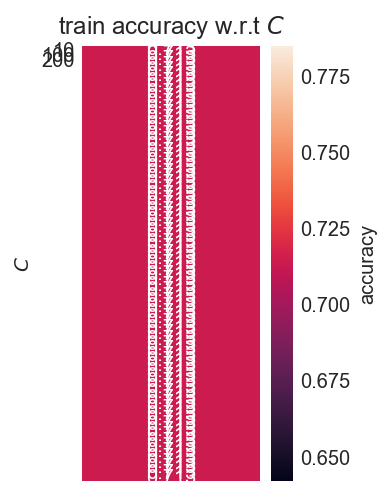

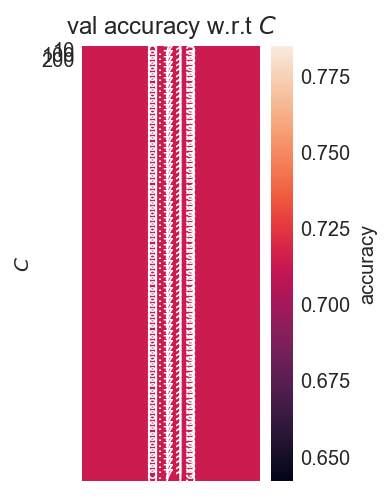

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.7126)

###########################################################################

Decision Tree Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7134)
('Test Accuracy: ', 0.7126)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


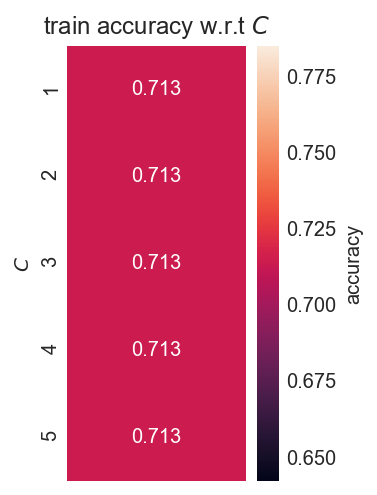

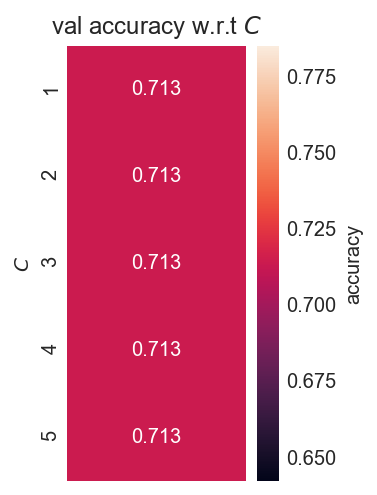

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.7126)

Trial #3
Adaboost Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7164)
('Test Accuracy: ', 0.705)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


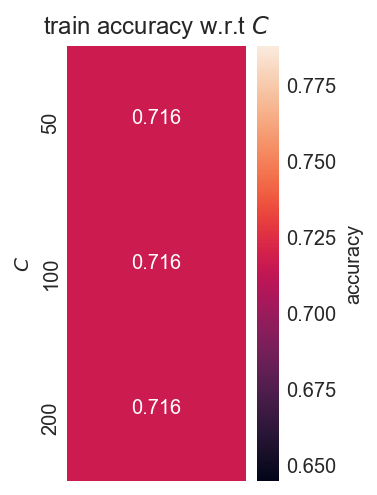

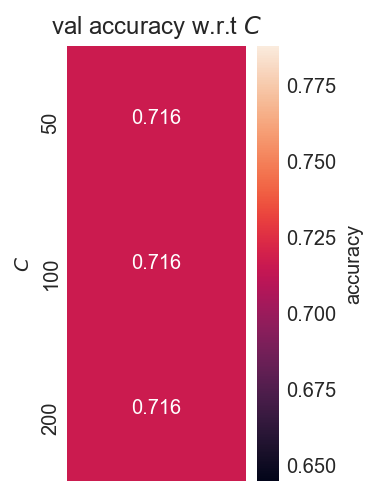

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.705)

###########################################################################

Random Forest Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7164)
('Test Accuracy: ', 0.705)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


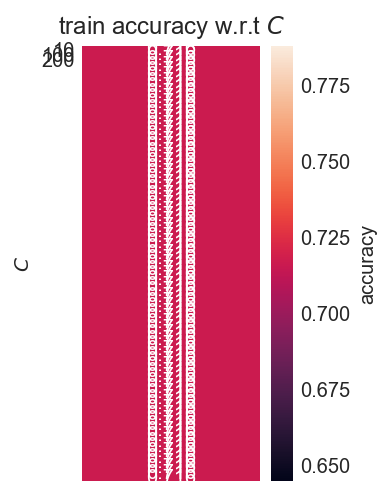

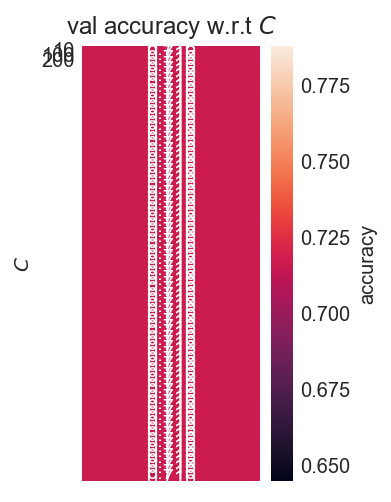

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.705)

###########################################################################

Decision Tree Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7164)
('Test Accuracy: ', 0.705)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


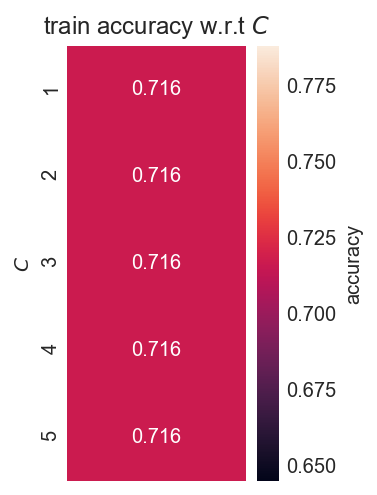

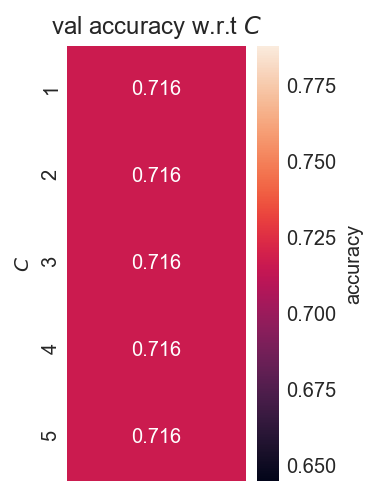

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.705)


In [14]:
#cell to call functions
print("NewsDF (50/50)")
print("----------------------------")
for num in range(0,3):
    
    print(("\nTrial #%d") % (num+1))
    adaBoost_avg,randForest_avg,DecisionTree_avg = newsDF_classifer(newsDF,.50,.50,
                                                                    adaBoost_avg,randForest_avg,DecisionTree_avg)

In [15]:
print(("Avg test error for Adaboost      (50/50): %f") % (float(adaBoost_avg / 3)))
print(("Avg test error for Random Forest (50/50): %f") % (float(randForest_avg / 3)))
print(("Avg test error for Decision Tree (50/50): %f") % (float(DecisionTree_avg / 3)))

#clear variables
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

Avg test error for Adaboost      (50/50): 0.712333
Avg test error for Random Forest (50/50): 0.712333
Avg test error for Decision Tree (50/50): 0.712333


NewsDF (20/80)
----------------------------

Trial #1
Adaboost Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.7035)
('Test Accuracy: ', 0.722125)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


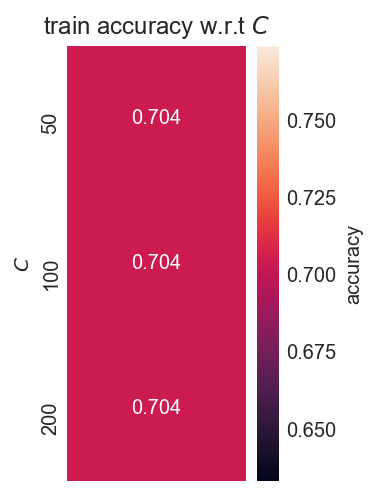

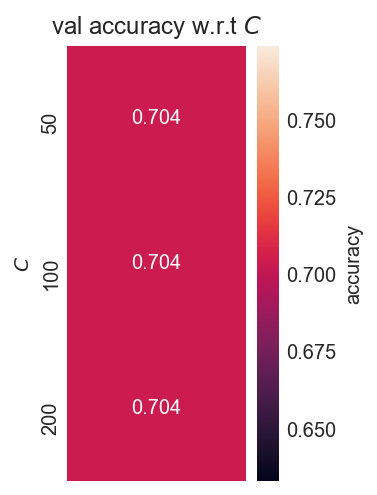

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.722125)

###########################################################################

Random Forest Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.7035)
('Test Accuracy: ', 0.722125)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


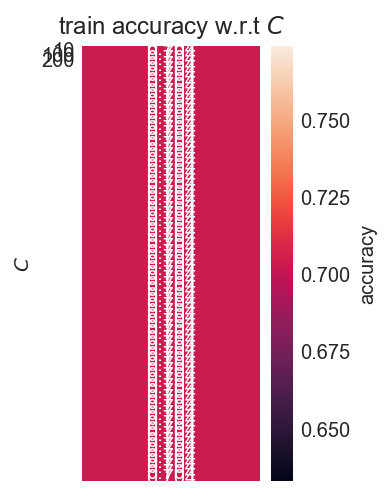

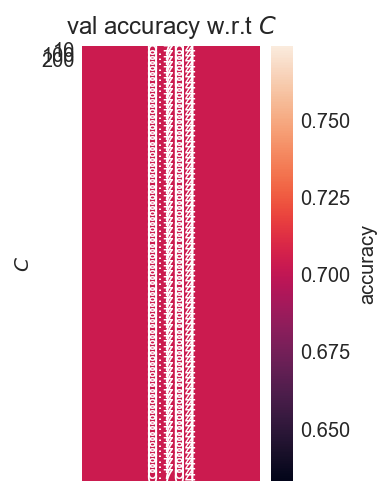

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.722125)

###########################################################################

Decision Tree Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.7035)
('Test Accuracy: ', 0.722125)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


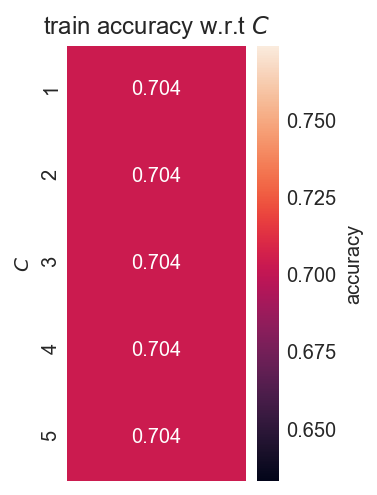

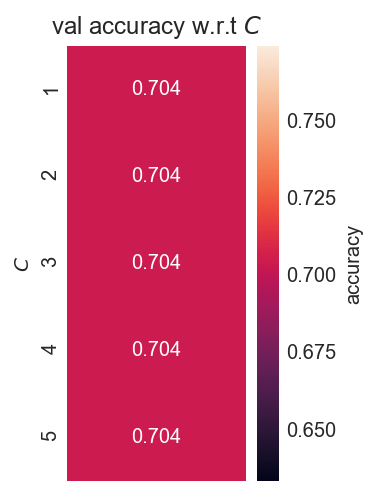

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.722125)

Trial #2
Adaboost Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.7135)
('Test Accuracy: ', 0.721125)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


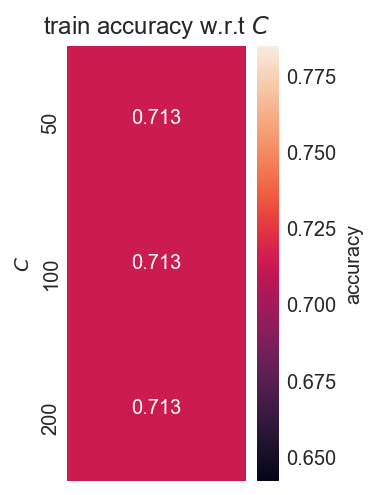

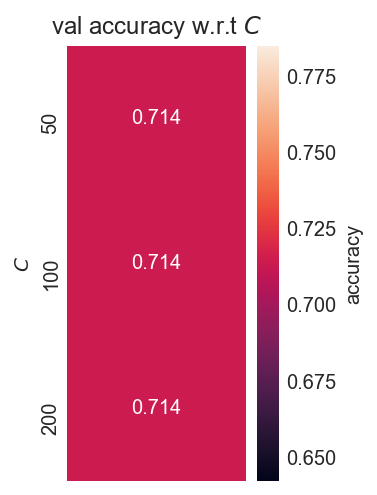

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.721125)

###########################################################################

Random Forest Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.7135)
('Test Accuracy: ', 0.721125)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


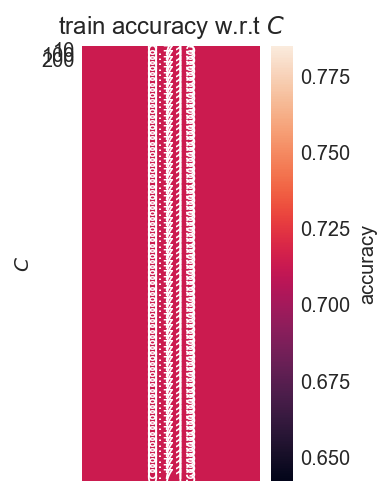

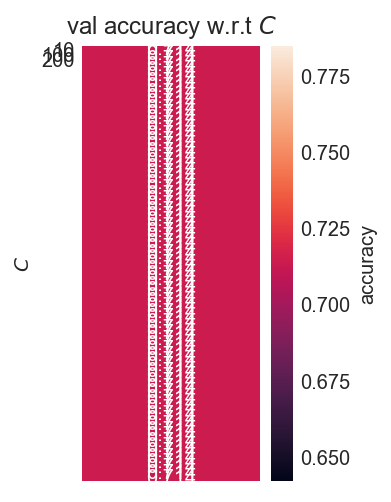

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.721125)

###########################################################################

Decision Tree Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.7135)
('Test Accuracy: ', 0.721125)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


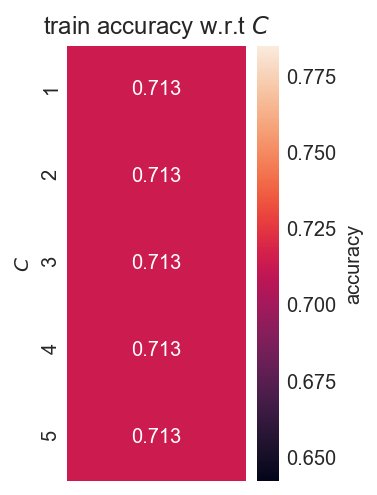

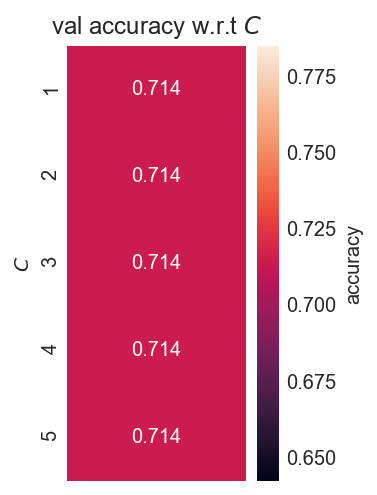

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.721125)

Trial #3
Adaboost Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.736)
('Test Accuracy: ', 0.717125)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


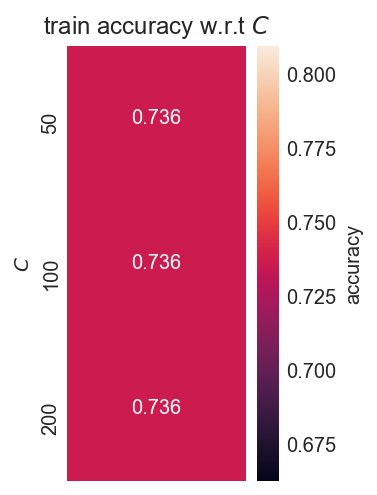

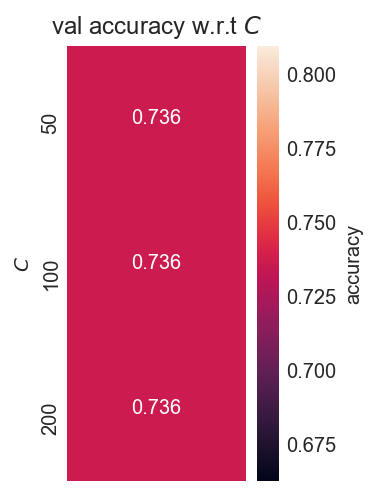

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.717125)

###########################################################################

Random Forest Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.736)
('Test Accuracy: ', 0.717125)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


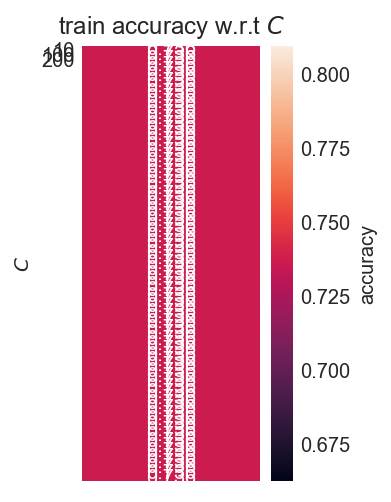

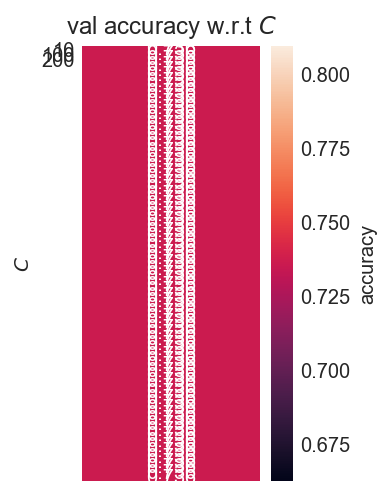

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.717125)

###########################################################################

Decision Tree Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.736)
('Test Accuracy: ', 0.717125)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


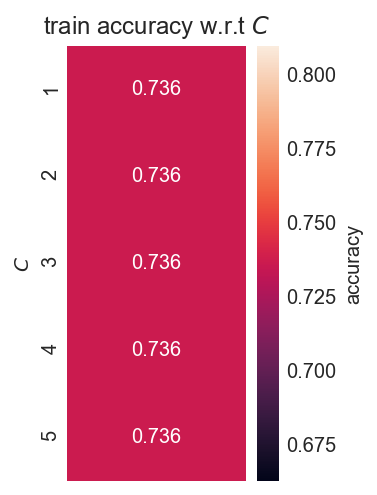

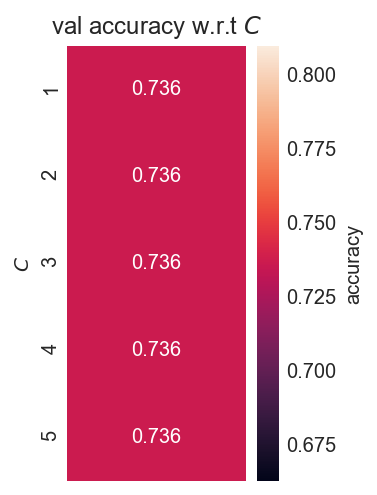

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.717125)


In [16]:
#cell to call functions
print("NewsDF (20/80)")
print("----------------------------")
for num in range(0,3):
    
    print(("\nTrial #%d") % (num+1))
    adaBoost_avg,randForest_avg,DecisionTree_avg = newsDF_classifer(newsDF,.20,.80,
                                                                    adaBoost_avg,randForest_avg,DecisionTree_avg)

In [17]:
print(("Avg test error for Adaboost      (20/80): %f") % (float(adaBoost_avg / 3)))
print(("Avg test error for Random Forest (20/80): %f") % (float(randForest_avg / 3)))
print(("Avg test error for Decision Tree (20/80): %f") % (float(DecisionTree_avg / 3)))

#clear variables
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

Avg test error for Adaboost      (20/80): 0.720125
Avg test error for Random Forest (20/80): 0.720125
Avg test error for Decision Tree (20/80): 0.720125


## cardDF

***

In [18]:
def cardDF_classifer(cardDF,train_split,test_split,adaBoost_avg,randForest_avg,DecisionTree_avg):
    
    # train/test Split
    train_split = train_split
    test_split  = test_split
    X_vals = cardDF.iloc[:,0:23]
    Y_vals = cardDF.iloc[:,24]

    #randomize rows
    temp_x = X_vals.sample(frac=1).reset_index(drop = True)
    temp_Y = Y_vals.sample(frac=1).reset_index(drop = True)

    #For testing Purpose, get smaller size of 5000 samples
    temp_x = temp_x.head(10000)
    temp_Y = temp_Y.head(10000)

    #separate into training and test sets
    split = int(train_split * len(temp_x))
    X_train = temp_x.iloc[:split, :]           # Get features from train + val set.
    X_test  = temp_x.iloc[split:, :]           # Get features from test set.     
    Y_train = temp_Y.iloc[: split]             # Get labels from train + val set.
    Y_test  = temp_Y.iloc[split :]             # Get labels from test set.


    #train Adaboost classifier
    Ada_clf = AdaBoostClassifier()
    Ada_clf.fit(X_train,Y_train)

    print("Adaboost Classifier")
    print("Split -- %f Training, %f Testing") % (train_split, test_split)
    print("Train Accuracy : ", Ada_clf.score(X_train,Y_train))
    print("Test Accuracy: ", Ada_clf.score(X_test,Y_test))
    print("\n")

    #perform cross validation and gridsearch to get best parameters
    parameters = {"n_estimators": [50,100,200]}
    grid_cv = GridSearchCV(Ada_clf, parameters, return_train_score = 'true' )
    grid_cv.fit(X_train,Y_train)
    print(grid_cv.best_estimator_)

    #get average accuracies
    train_acc = grid_cv.cv_results_['mean_train_score']
    val_acc = grid_cv.cv_results_['mean_test_score']

    #print heat maps
    draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', [50,100,200] )
    draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', [50,100,200])

    #print best hyper-parameter(s)
    print("Best number of estimators: ", grid_cv.best_params_["n_estimators"])

    #store test accuracy
    adaBoost_avg = adaBoost_avg + grid_cv.score(X_test,Y_test)
    
    #Test Accuracy with best hyper-parameter
    print("Test Accuracy with best hyper-parameter: " , grid_cv.score(X_test,Y_test))

    print("\n###########################################################################\n")

    #train Random Forest classifier
    rand_forest_clf = RandomForestClassifier()
    rand_forest_clf.fit(X_train,Y_train)

    print("Random Forest Classifier")
    print("Split -- %f Training, %f Testing") % (train_split, test_split)
    print("Train Accuracy : ", rand_forest_clf.score(X_train,Y_train))
    print("Test Accuracy: ", rand_forest_clf.score(X_test,Y_test))
    print("\n")

    #perform cross validation and gridsearch to get best parameters
    parameters = {"n_estimators": [10,100,200],"max_depth":[2,4,6],"min_samples_split": [50,100,200]
                 , "min_samples_leaf": [1,2,4]}

    grid_cv = GridSearchCV(rand_forest_clf, parameters, return_train_score = 'true' )
    grid_cv.fit(X_train,Y_train)
    print(grid_cv.best_estimator_)

    #get average accuracies
    train_acc = grid_cv.cv_results_['mean_train_score']
    val_acc = grid_cv.cv_results_['mean_test_score']

    #print heat maps
    draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', [10,100,200] )
    draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', [10,100,200])

    #print best hyper-parameter(s)
    print("Best number of estimators: ", grid_cv.best_params_["n_estimators"])
    print("Best Max Depth: ", grid_cv.best_params_["max_depth"])

    #store test accuracy
    randForest_avg = randForest_avg + grid_cv.score(X_test,Y_test)
    
    #Test Accuracy with best hyper-parameter
    print("Test Accuracy with best hyper-parameter: " , grid_cv.score(X_test,Y_test))

    print("\n###########################################################################\n")

    #train SVM classifier
    DT_clf = DecisionTreeClassifier()
    DT_clf.fit(X_train,Y_train)

    print("Decision Tree Classifier")
    print("Split -- %f Training, %f Testing") % (train_split, test_split)
    print("Train Accuracy : ", DT_clf.score(X_train,Y_train))
    print("Test Accuracy: ", DT_clf.score(X_test,Y_test))
    print("\n")

    #perform cross validation and gridsearch to get best parameters
    parameters = {"max_depth":[1,2,3,4,5]}
    grid_cv = GridSearchCV(DT_clf, parameters, return_train_score = 'true' )
    grid_cv.fit(X_train,Y_train)
    print(grid_cv.best_estimator_)

    #get average accuracies
    train_acc = grid_cv.cv_results_['mean_train_score']
    val_acc = grid_cv.cv_results_['mean_test_score']

    #print heat maps
    draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', [1,2,3,4,5] )
    draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', [1,2,3,4,5])

    #print best hyper-parameter(s)
    print("Best Max_Depth: ", grid_cv.best_params_["max_depth"])

    #store test accuracy
    DecisionTree_avg = DecisionTree_avg + grid_cv.score(X_test,Y_test)
    
    #Test Accuracy with best hyper-parameter
    print("Test Accuracy with best hyper-parameter(s): " , grid_cv.score(X_test,Y_test))
    
    return adaBoost_avg,randForest_avg,DecisionTree_avg

CardDF (80/20)
----------------------------

Trial #1
 ---------
Adaboost Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.77875)
('Test Accuracy: ', 0.7735)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


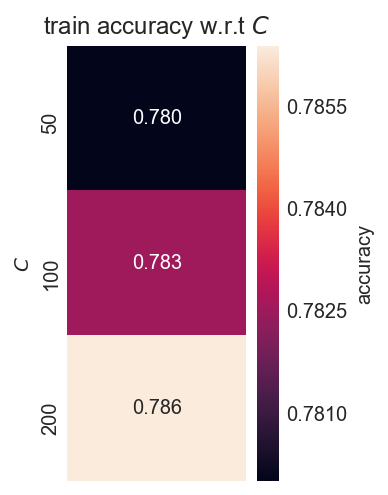

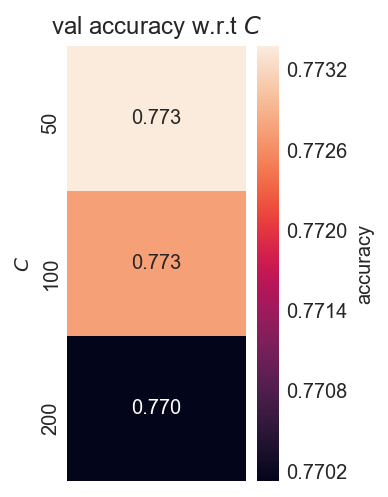

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7735)

###########################################################################

Random Forest Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.971625)
('Test Accuracy: ', 0.7575)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


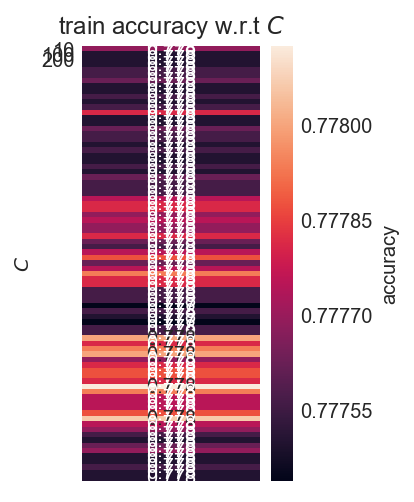

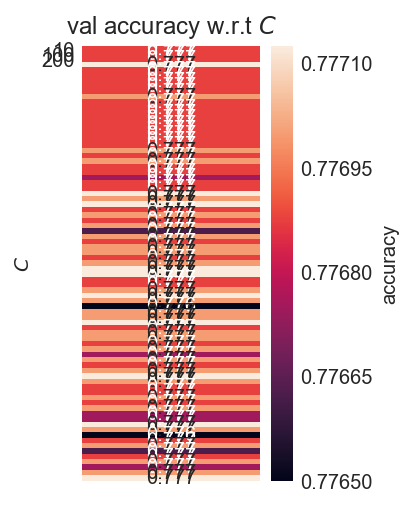

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.7755)

###########################################################################

Decision Tree Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.6325)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


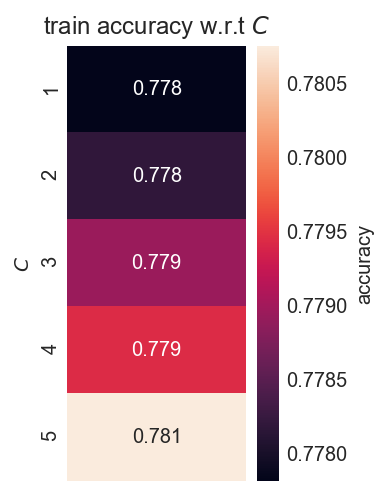

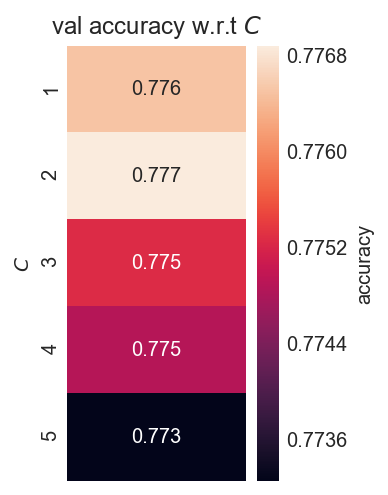

('Best Max_Depth: ', 2)
('Test Accuracy with best hyper-parameter(s): ', 0.7755)

Trial #2
 ---------
Adaboost Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.783875)
('Test Accuracy: ', 0.7795)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


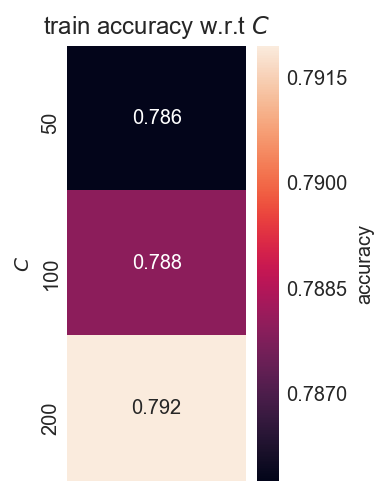

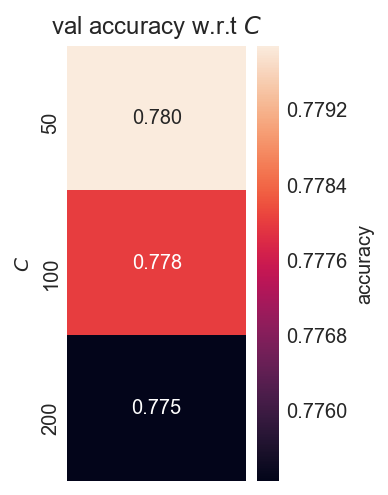

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7795)

###########################################################################

Random Forest Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.977)
('Test Accuracy: ', 0.768)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


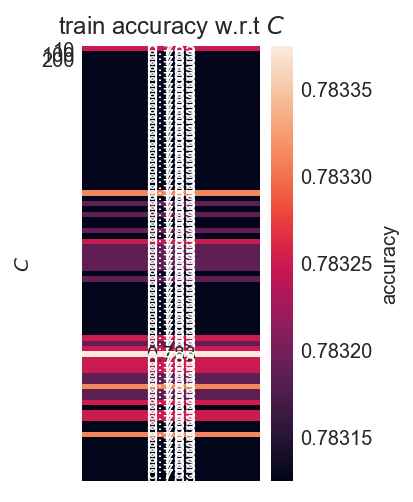

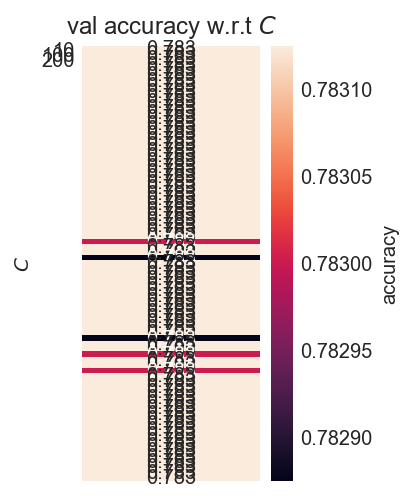

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.7805)

###########################################################################

Decision Tree Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.6505)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


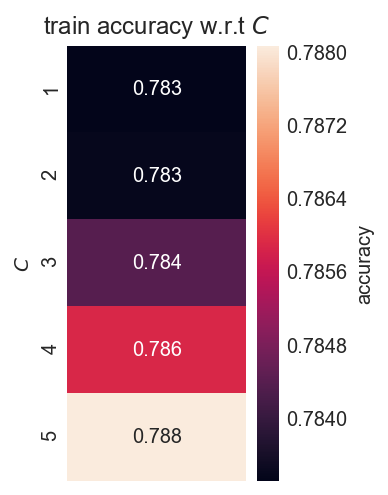

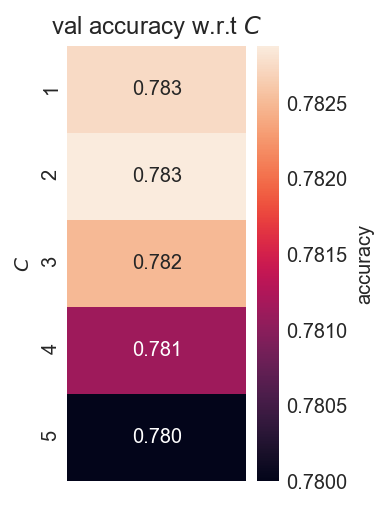

('Best Max_Depth: ', 2)
('Test Accuracy with best hyper-parameter(s): ', 0.7775)

Trial #3
 ---------
Adaboost Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.77625)
('Test Accuracy: ', 0.782)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


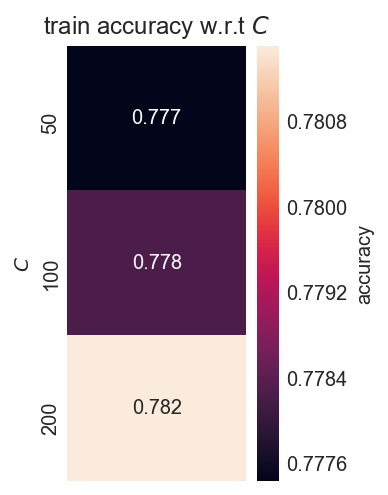

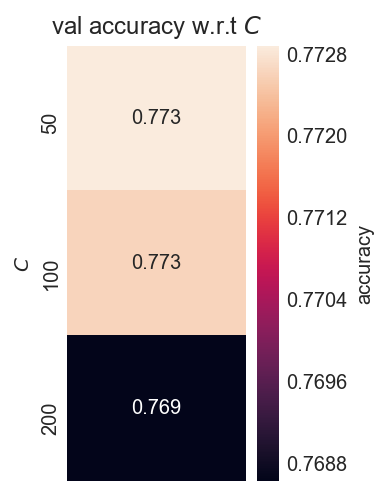

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.782)

###########################################################################

Random Forest Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.97025)
('Test Accuracy: ', 0.7685)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


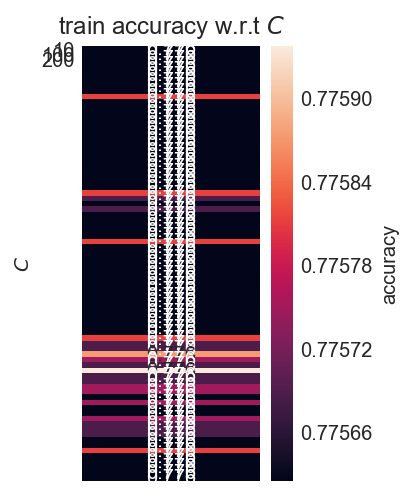

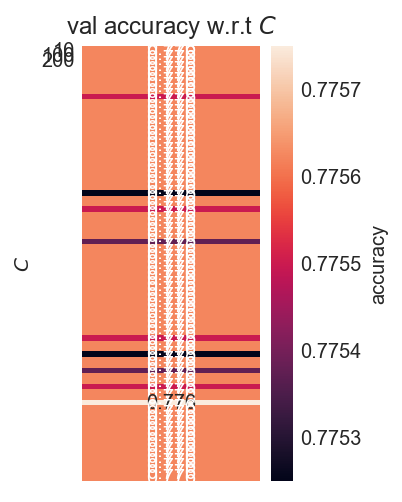

('Best number of estimators: ', 10)
('Best Max Depth: ', 6)
('Test Accuracy with best hyper-parameter: ', 0.7815)

###########################################################################

Decision Tree Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.645)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


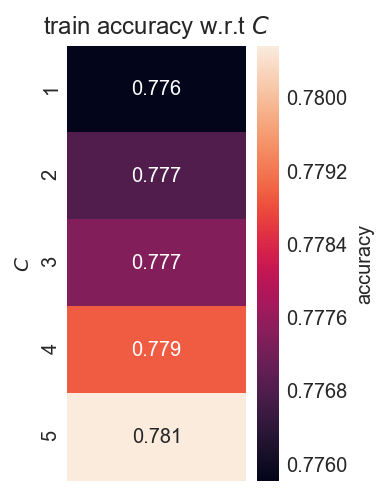

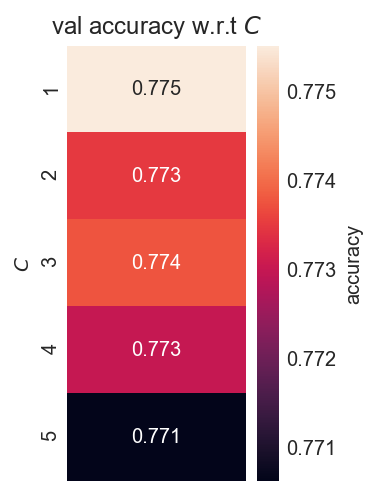

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.782)


In [19]:
#cell to call functions
print("CardDF (80/20)")
print("----------------------------")
for num in range(0,3):
    
    print(("\nTrial #%d\n ---------") % (num+1))
    adaBoost_avg,randForest_avg,DecisionTree_avg = cardDF_classifer(cardDF,.80,.20,
                                                                    adaBoost_avg,randForest_avg,DecisionTree_avg)

In [20]:
print(("Avg test error for Adaboost      (80/20): %f") % (float(adaBoost_avg / 3)))
print(("Avg test error for Random Forest (80/20): %f") % (float(randForest_avg / 3)))
print(("Avg test error for Decision Tree (80/20): %f") % (float(DecisionTree_avg / 3)))

#clear variables
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

Avg test error for Adaboost      (80/20): 0.778333
Avg test error for Random Forest (80/20): 0.779167
Avg test error for Decision Tree (80/20): 0.778333


cardDF (50/50)
----------------------------

Trial #1
Adaboost Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7842)
('Test Accuracy: ', 0.7694)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


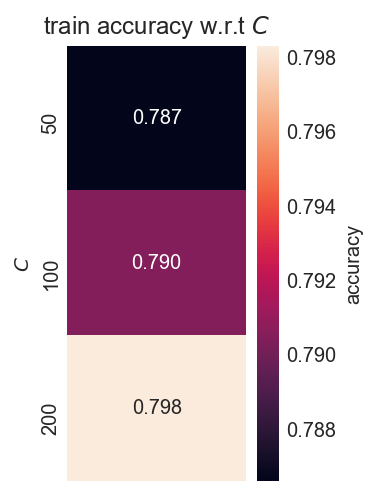

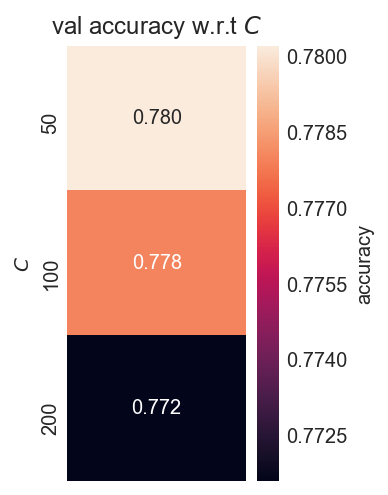

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7694)

###########################################################################

Random Forest Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.972)
('Test Accuracy: ', 0.7528)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


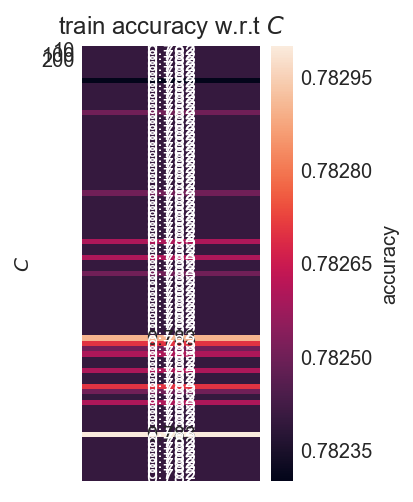

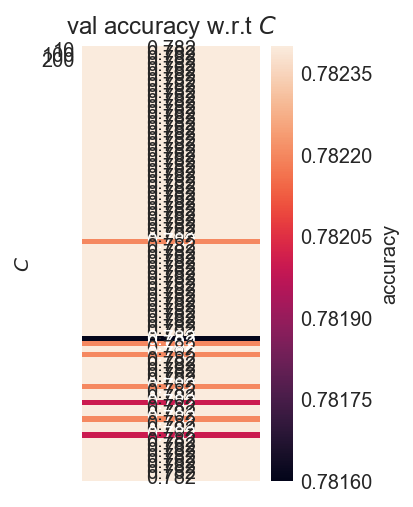

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.7734)

###########################################################################

Decision Tree Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.634)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


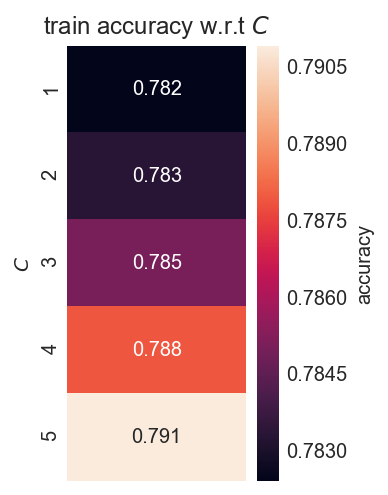

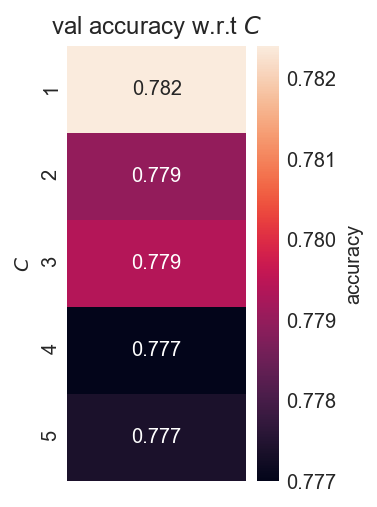

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.7734)

Trial #2
Adaboost Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7732)
('Test Accuracy: ', 0.7728)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


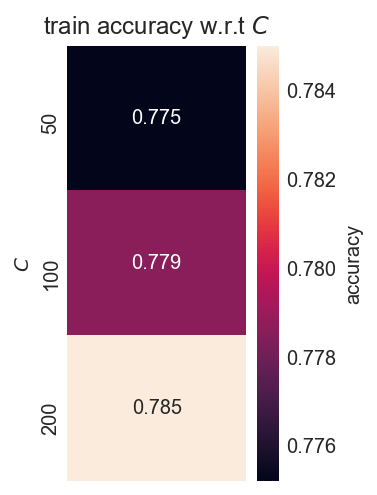

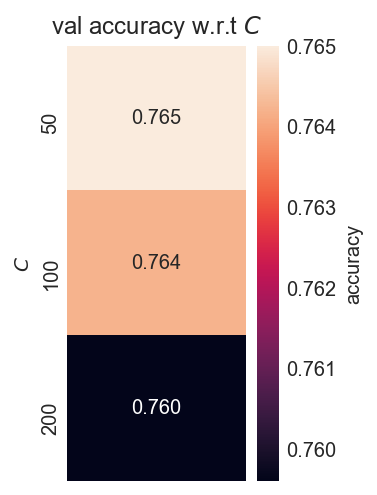

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7728)

###########################################################################

Random Forest Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.9714)
('Test Accuracy: ', 0.7482)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


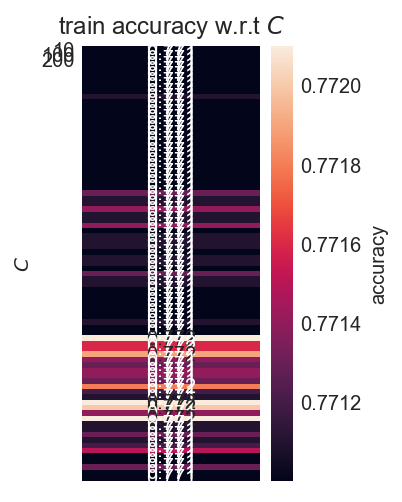

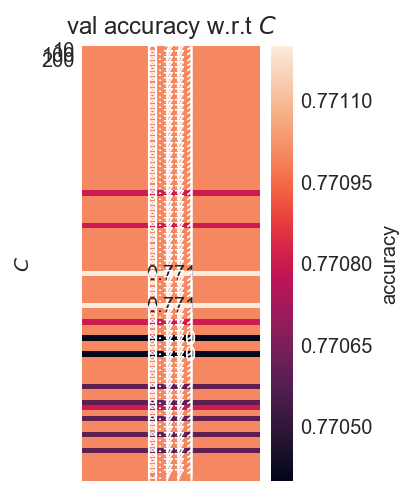

('Best number of estimators: ', 10)
('Best Max Depth: ', 4)
('Test Accuracy with best hyper-parameter: ', 0.775)

###########################################################################

Decision Tree Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.6342)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


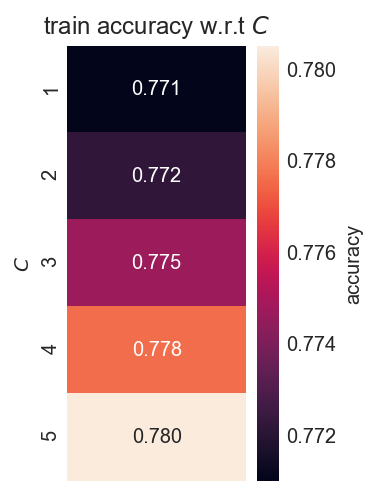

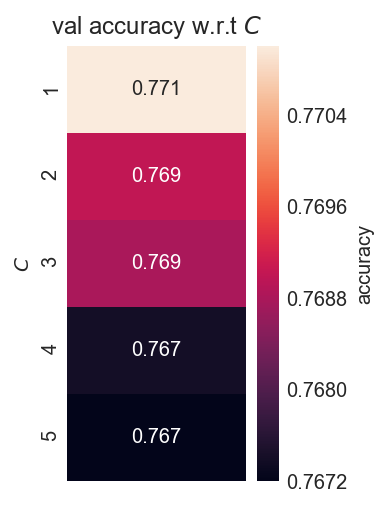

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.775)

Trial #3
Adaboost Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.7882)
('Test Accuracy: ', 0.7768)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


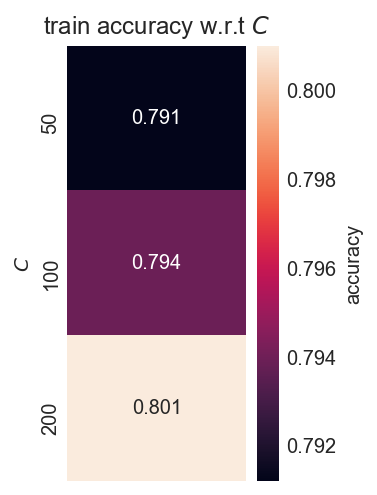

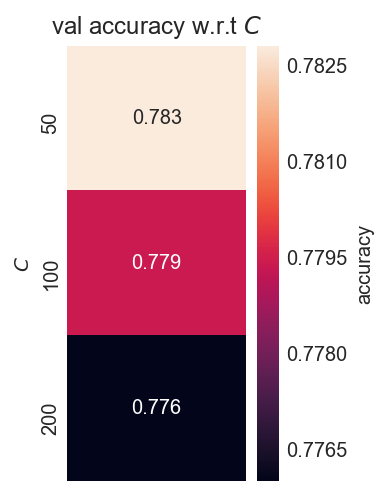

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7768)

###########################################################################

Random Forest Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.9674)
('Test Accuracy: ', 0.765)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


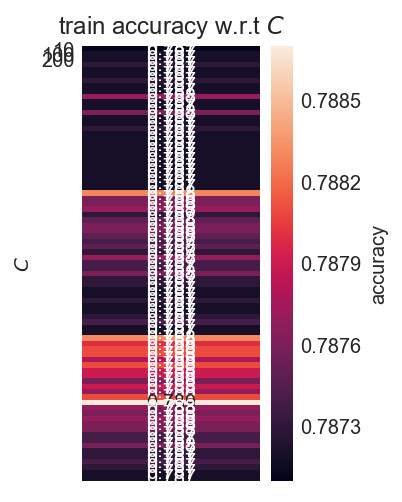

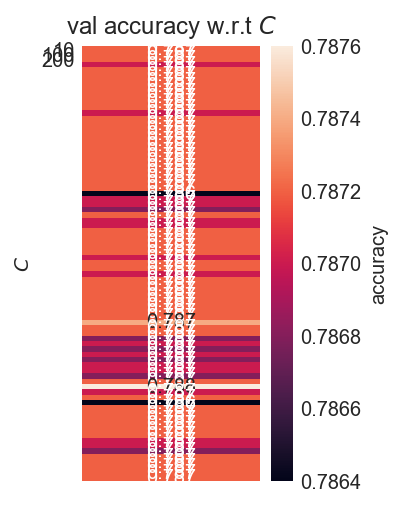

('Best number of estimators: ', 10)
('Best Max Depth: ', 6)
('Test Accuracy with best hyper-parameter: ', 0.778)

###########################################################################

Decision Tree Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.6632)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


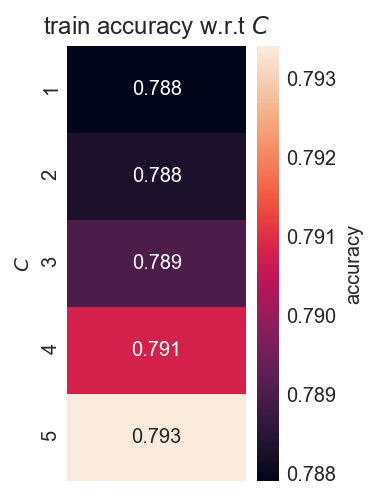

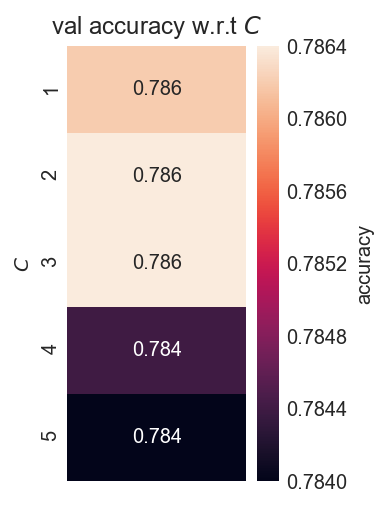

('Best Max_Depth: ', 2)
('Test Accuracy with best hyper-parameter(s): ', 0.778)


In [21]:
#cell to call functions
print("cardDF (50/50)")
print("----------------------------")
for num in range(0,3):
    
    print(("\nTrial #%d") % (num+1))
    adaBoost_avg,randForest_avg,DecisionTree_avg = cardDF_classifer(cardDF,.50,.50,
                                                                    adaBoost_avg,randForest_avg,DecisionTree_avg)

In [22]:
print(("Avg test error for Adaboost      (50/50): %f") % (float(adaBoost_avg / 3)))
print(("Avg test error for Random Forest (50/50): %f") % (float(randForest_avg / 3)))
print(("Avg test error for Decision Tree (50/50): %f") % (float(DecisionTree_avg / 3)))

#clear variables
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

Avg test error for Adaboost      (50/50): 0.773000
Avg test error for Random Forest (50/50): 0.775467
Avg test error for Decision Tree (50/50): 0.775467


cardDF (20/80)
----------------------------

Trial #1
Adaboost Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.792)
('Test Accuracy: ', 0.7645)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


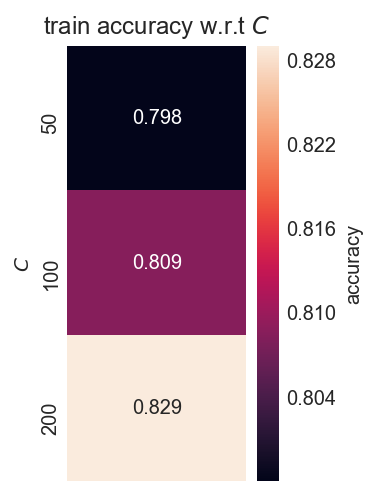

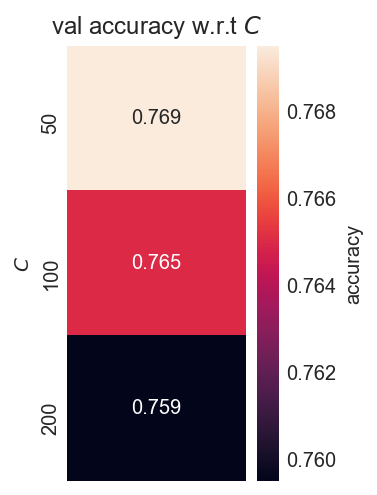

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7645)

###########################################################################

Random Forest Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.975)
('Test Accuracy: ', 0.7615)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


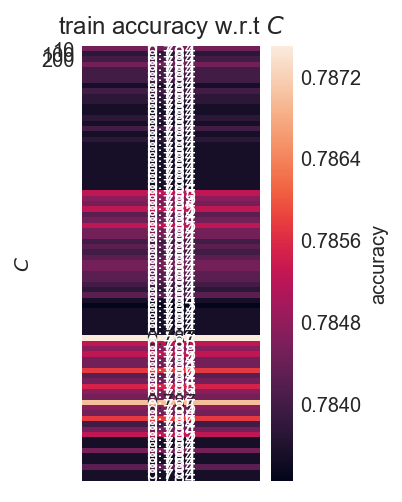

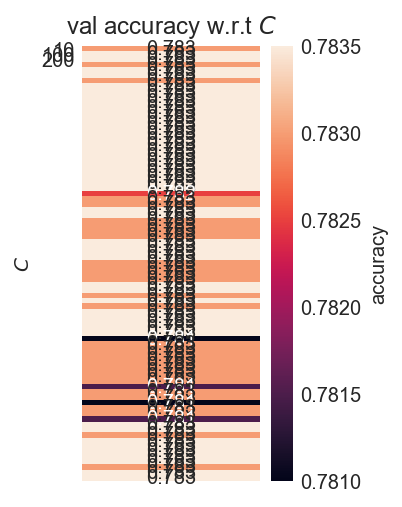

('Best number of estimators: ', 100)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.778375)

###########################################################################

Decision Tree Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.64725)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


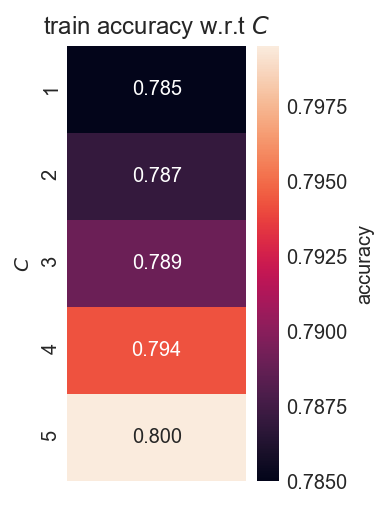

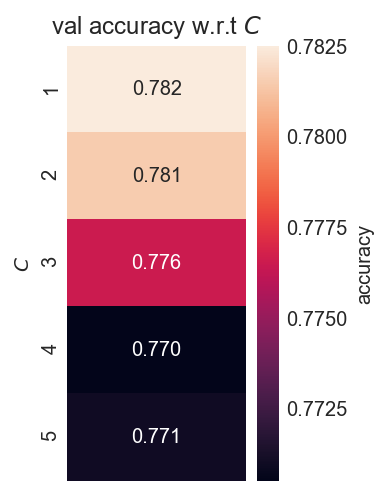

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.778375)

Trial #2
Adaboost Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.775)
('Test Accuracy: ', 0.7655)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


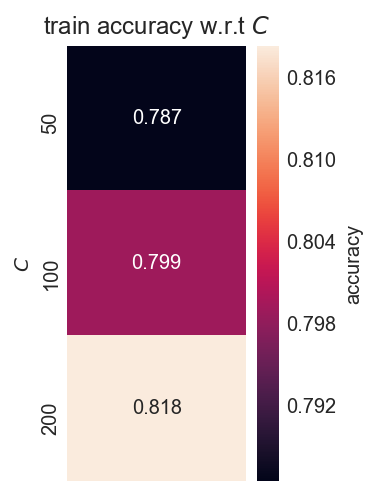

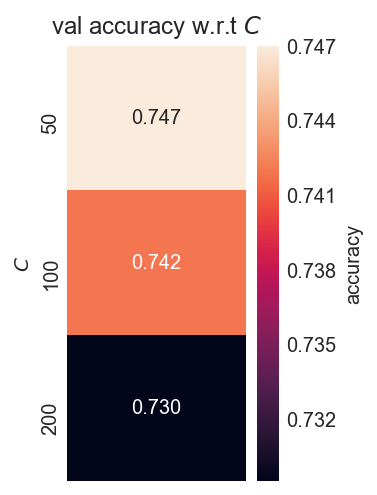

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.7655)

###########################################################################

Random Forest Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.97)
('Test Accuracy: ', 0.7545)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


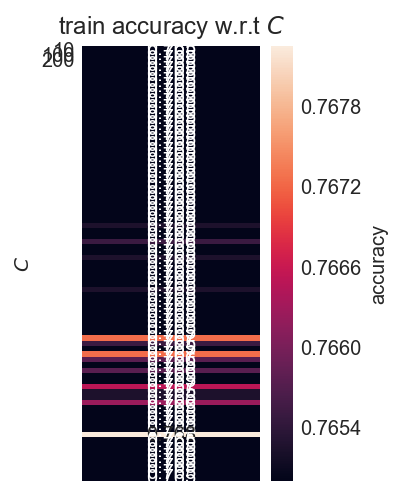

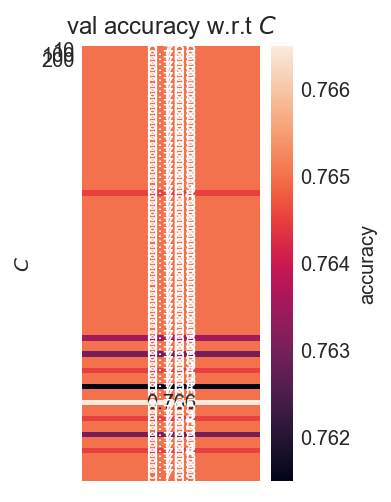

('Best number of estimators: ', 10)
('Best Max Depth: ', 6)
('Test Accuracy with best hyper-parameter: ', 0.778)

###########################################################################

Decision Tree Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.618125)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


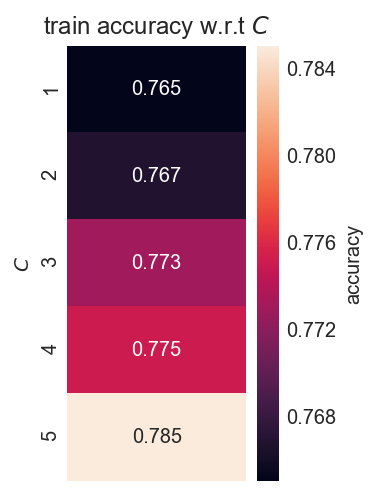

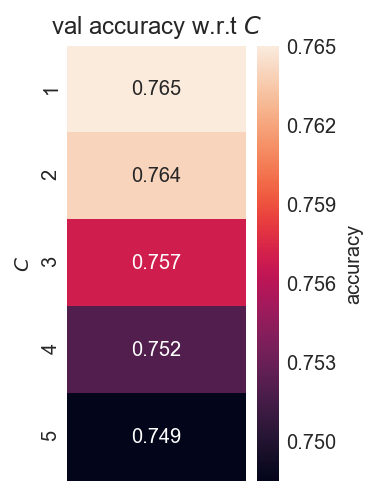

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.778625)

Trial #3
Adaboost Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.808)
('Test Accuracy: ', 0.775125)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


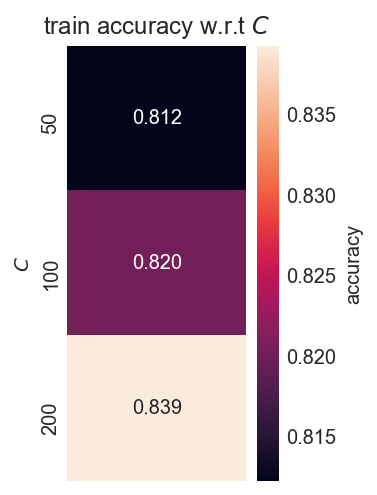

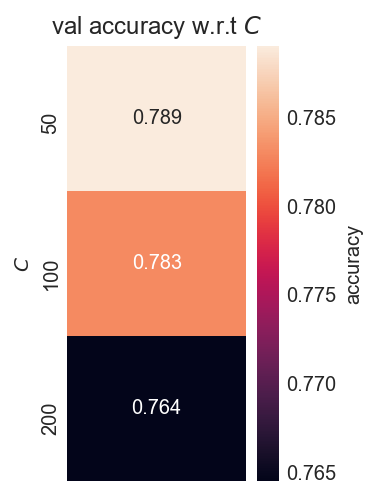

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.775125)

###########################################################################

Random Forest Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.975)
('Test Accuracy: ', 0.76575)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


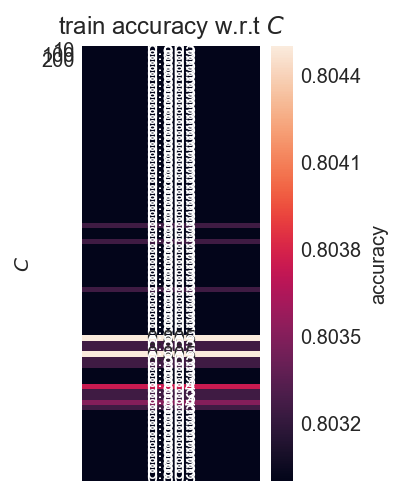

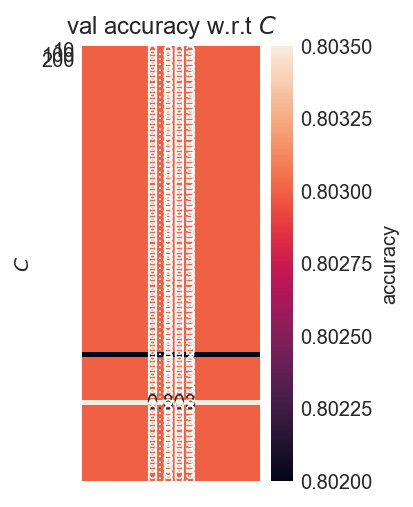

('Best number of estimators: ', 10)
('Best Max Depth: ', 6)
('Test Accuracy with best hyper-parameter: ', 0.77975)

###########################################################################

Decision Tree Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.65375)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


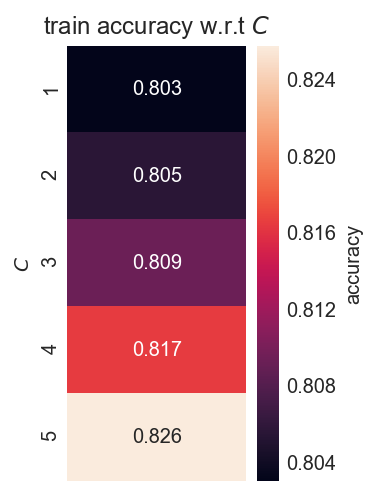

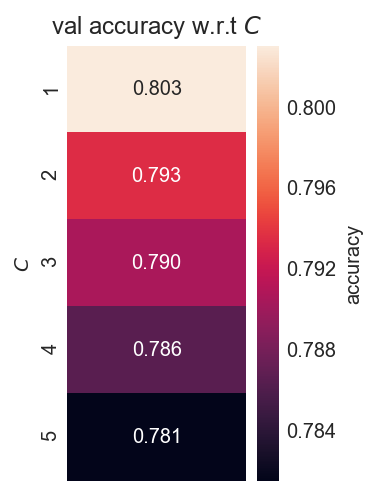

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.77975)


In [23]:
#cell to call functions
print("cardDF (20/80)")
print("----------------------------")
for num in range(0,3):
    
    print(("\nTrial #%d") % (num+1))
    adaBoost_avg,randForest_avg,DecisionTree_avg = cardDF_classifer(cardDF,.20,.80,
                                                                    adaBoost_avg,randForest_avg,DecisionTree_avg)

In [24]:
print(("Avg test error for Adaboost      (20/80): %f") % (float(adaBoost_avg / 3)))
print(("Avg test error for Random Forest (20/80): %f") % (float(randForest_avg / 3)))
print(("Avg test error for Decision Tree (20/80): %f") % (float(DecisionTree_avg / 3)))

#clear variables
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

Avg test error for Adaboost      (20/80): 0.768375
Avg test error for Random Forest (20/80): 0.778708
Avg test error for Decision Tree (20/80): 0.778917


In [26]:
def covDF_classifer(covDF,train_split,test_split,adaBoost_avg,randForest_avg,DecisionTree_avg):
    
    # train/test Split
    train_split = train_split
    test_split  = test_split
    X_vals = covDF.iloc[:,0:53]
    Y_vals = covDF.iloc[:,54]

    #randomize rows
    temp_x = X_vals.sample(frac=1).reset_index(drop = True)
    temp_Y = Y_vals.sample(frac=1).reset_index(drop = True)

    #For testing Purpose, get smaller size of 5000 samples
    temp_x = temp_x.head(10000)
    temp_Y = temp_Y.head(10000)

    #separate into training and test sets
    split = int(train_split * len(temp_x))
    X_train = temp_x.iloc[:split, :]           # Get features from train + val set.
    X_test  = temp_x.iloc[split:, :]           # Get features from test set.     
    Y_train = temp_Y.iloc[: split]             # Get labels from train + val set.
    Y_test  = temp_Y.iloc[split :]             # Get labels from test set.


    #train Adaboost classifier
    Ada_clf = AdaBoostClassifier()
    Ada_clf.fit(X_train,Y_train)

    print("Adaboost Classifier")
    print("Split -- %f Training, %f Testing") % (train_split, test_split)
    print("Train Accuracy : ", Ada_clf.score(X_train,Y_train))
    print("Test Accuracy: ", Ada_clf.score(X_test,Y_test))
    print("\n")

    #perform cross validation and gridsearch to get best parameters
    parameters = {"n_estimators": [50,100,200]}
    grid_cv = GridSearchCV(Ada_clf, parameters, return_train_score = 'true' )
    grid_cv.fit(X_train,Y_train)
    print(grid_cv.best_estimator_)

    #get average accuracies
    train_acc = grid_cv.cv_results_['mean_train_score']
    val_acc = grid_cv.cv_results_['mean_test_score']

    #print heat maps
    draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', [50,100,200] )
    draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', [50,100,200])

    #print best hyper-parameter(s)
    print("Best number of estimators: ", grid_cv.best_params_["n_estimators"])

    #store test accuracy
    adaBoost_avg = adaBoost_avg + grid_cv.score(X_test,Y_test)
    
    #Test Accuracy with best hyper-parameter
    print("Test Accuracy with best hyper-parameter: " , grid_cv.score(X_test,Y_test))

    print("\n###########################################################################\n")

    #train Random Forest classifier
    rand_forest_clf = RandomForestClassifier()
    rand_forest_clf.fit(X_train,Y_train)

    print("Random Forest Classifier")
    print("Split -- %f Training, %f Testing") % (train_split, test_split)
    print("Train Accuracy : ", rand_forest_clf.score(X_train,Y_train))
    print("Test Accuracy: ", rand_forest_clf.score(X_test,Y_test))
    print("\n")

    #perform cross validation and gridsearch to get best parameters
    parameters = {"n_estimators": [10,100,200],"max_depth":[2,4,6],"min_samples_split": [50,100,200]
                 , "min_samples_leaf": [1,2,4]}

    grid_cv = GridSearchCV(rand_forest_clf, parameters, return_train_score = 'true' )
    grid_cv.fit(X_train,Y_train)
    print(grid_cv.best_estimator_)

    #get average accuracies
    train_acc = grid_cv.cv_results_['mean_train_score']
    val_acc = grid_cv.cv_results_['mean_test_score']

    #print heat maps
    draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', [10,100,200] )
    draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', [10,100,200])

    #print best hyper-parameter(s)
    print("Best number of estimators: ", grid_cv.best_params_["n_estimators"])
    print("Best Max Depth: ", grid_cv.best_params_["max_depth"])

    #store test accuracy
    randForest_avg = randForest_avg + grid_cv.score(X_test,Y_test)
    
    #Test Accuracy with best hyper-parameter
    print("Test Accuracy with best hyper-parameter: " , grid_cv.score(X_test,Y_test))

    print("\n###########################################################################\n")

    #train SVM classifier
    DT_clf = DecisionTreeClassifier()
    DT_clf.fit(X_train,Y_train)

    print("Decision Tree Classifier")
    print("Split -- %f Training, %f Testing") % (train_split, test_split)
    print("Train Accuracy : ", DT_clf.score(X_train,Y_train))
    print("Test Accuracy: ", DT_clf.score(X_test,Y_test))
    print("\n")

    #perform cross validation and gridsearch to get best parameters
    parameters = {"max_depth":[1,2,3,4,5]}
    grid_cv = GridSearchCV(DT_clf, parameters, return_train_score = 'true' )
    grid_cv.fit(X_train,Y_train)
    print(grid_cv.best_estimator_)

    #get average accuracies
    train_acc = grid_cv.cv_results_['mean_train_score']
    val_acc = grid_cv.cv_results_['mean_test_score']

    #print heat maps
    draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', [1,2,3,4,5] )
    draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', [1,2,3,4,5])

    #print best hyper-parameter(s)
    print("Best Max_Depth: ", grid_cv.best_params_["max_depth"])

    #store test accuracy
    DecisionTree_avg = DecisionTree_avg + grid_cv.score(X_test,Y_test)
    
    #Test Accuracy with best hyper-parameter
    print("Test Accuracy with best hyper-parameter(s): " , grid_cv.score(X_test,Y_test))
    
    return adaBoost_avg,randForest_avg,DecisionTree_avg

covDF (80/20)
----------------------------

Trial #1
 ---------
Adaboost Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.555875)
('Test Accuracy: ', 0.4945)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)


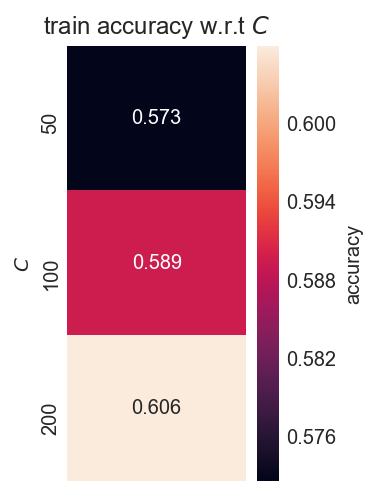

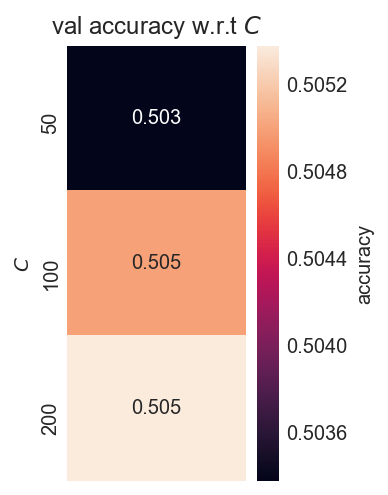

('Best number of estimators: ', 200)
('Test Accuracy with best hyper-parameter: ', 0.5085)

###########################################################################

Random Forest Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.983)
('Test Accuracy: ', 0.492)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


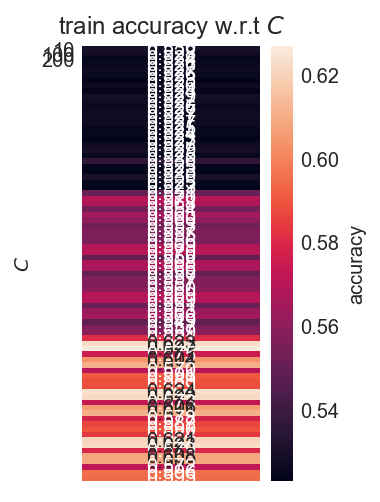

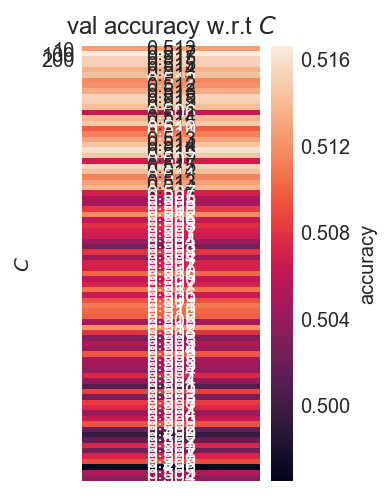

('Best number of estimators: ', 100)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.495)

###########################################################################

Decision Tree Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.4935)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


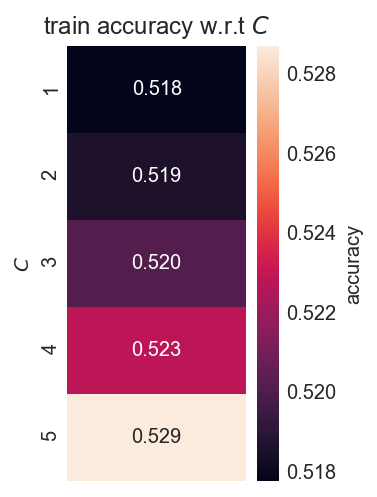

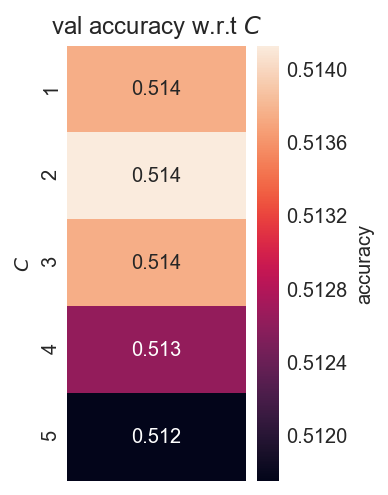

('Best Max_Depth: ', 2)
('Test Accuracy with best hyper-parameter(s): ', 0.4955)

Trial #2
 ---------
Adaboost Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.55425)
('Test Accuracy: ', 0.5165)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)


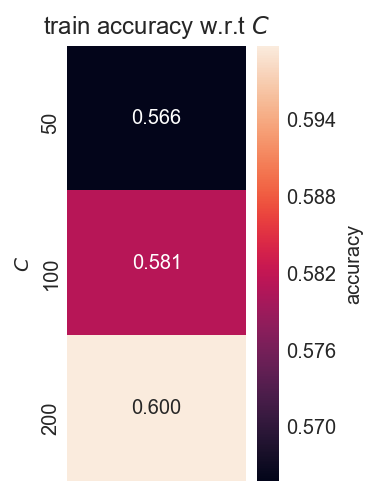

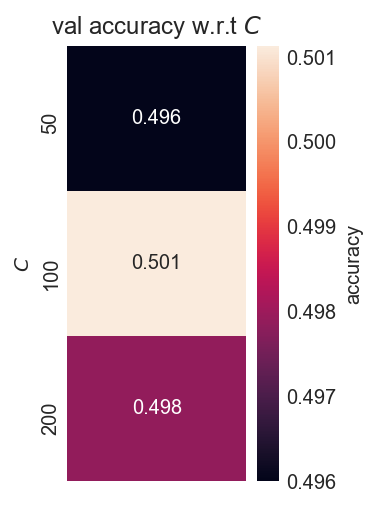

('Best number of estimators: ', 100)
('Test Accuracy with best hyper-parameter: ', 0.5145)

###########################################################################

Random Forest Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.982125)
('Test Accuracy: ', 0.499)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


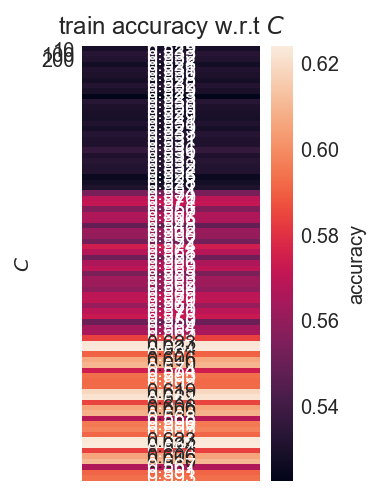

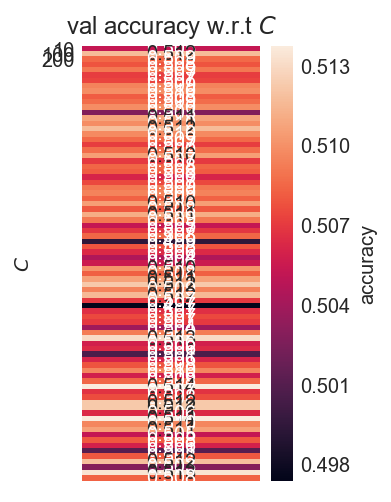

('Best number of estimators: ', 10)
('Best Max Depth: ', 6)
('Test Accuracy with best hyper-parameter: ', 0.5085)

###########################################################################

Decision Tree Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.522)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


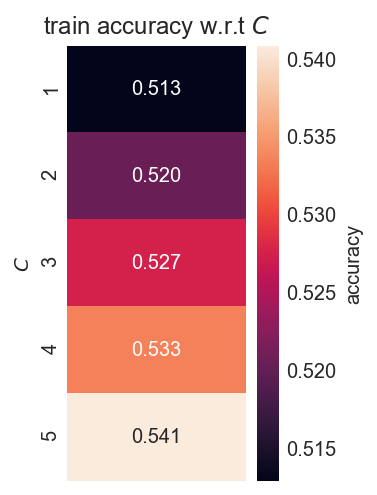

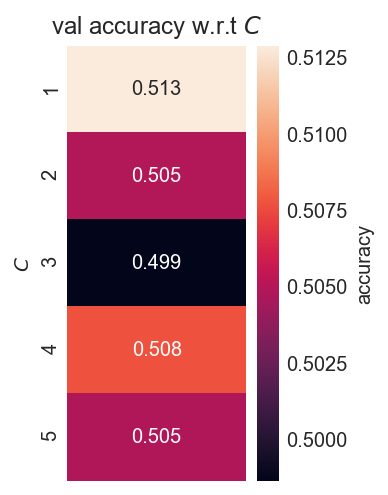

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.489)

Trial #3
 ---------
Adaboost Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.547875)
('Test Accuracy: ', 0.5005)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)


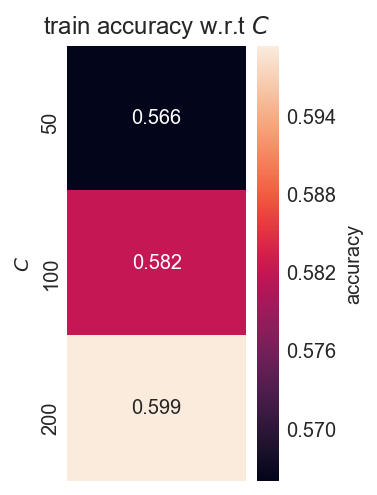

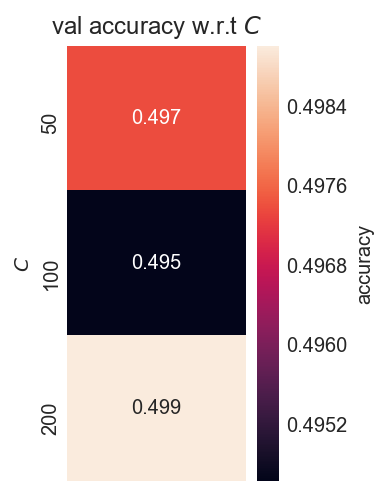

('Best number of estimators: ', 200)
('Test Accuracy with best hyper-parameter: ', 0.487)

###########################################################################

Random Forest Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 0.9805)
('Test Accuracy: ', 0.489)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


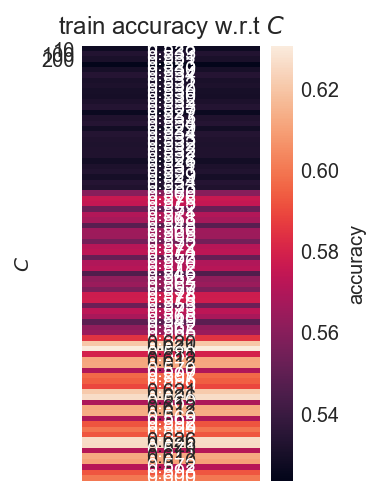

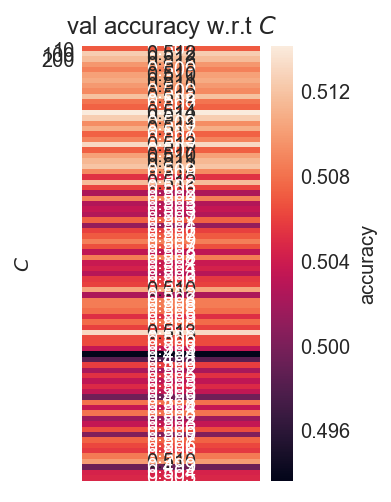

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.512)

###########################################################################

Decision Tree Classifier
Split -- 0.800000 Training, 0.200000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.508)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


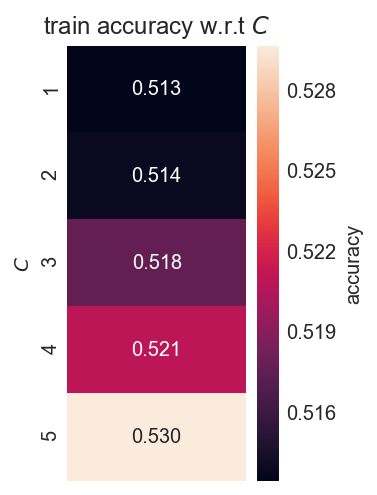

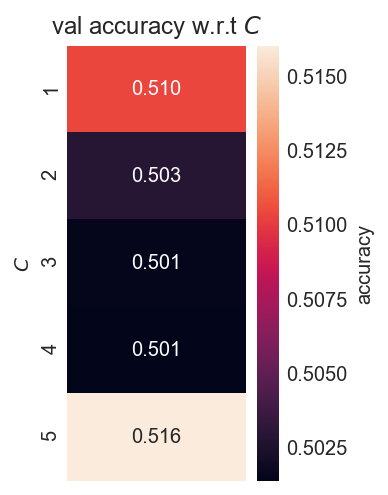

('Best Max_Depth: ', 5)
('Test Accuracy with best hyper-parameter(s): ', 0.5035)


In [27]:
#cell to call functions
print("covDF (80/20)")
print("----------------------------")
for num in range(0,3):
    
    print(("\nTrial #%d\n ---------") % (num+1))
    adaBoost_avg,randForest_avg,DecisionTree_avg = covDF_classifer(covDF,.80,.20,
                                                                    adaBoost_avg,randForest_avg,DecisionTree_avg)

In [28]:
print(("Avg test error for Adaboost      (80/20): %f") % (float(adaBoost_avg / 3)))
print(("Avg test error for Random Forest (80/20): %f") % (float(randForest_avg / 3)))
print(("Avg test error for Decision Tree (80/20): %f") % (float(DecisionTree_avg / 3)))

#clear variables
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

Avg test error for Adaboost      (80/20): 0.503333
Avg test error for Random Forest (80/20): 0.505167
Avg test error for Decision Tree (80/20): 0.496000


covDF (50/50)
----------------------------

Trial #1
Adaboost Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.562)
('Test Accuracy: ', 0.5086)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


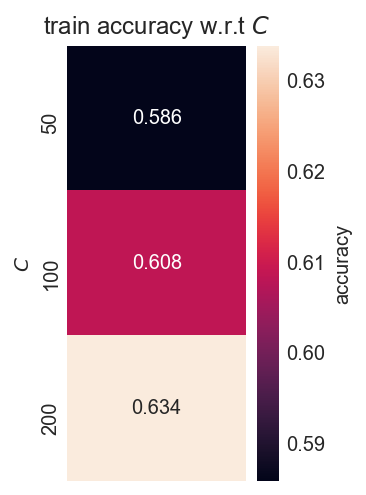

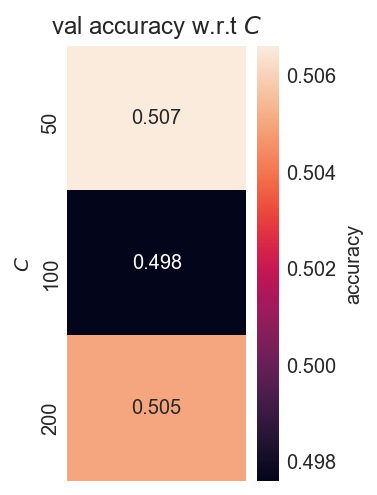

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.5086)

###########################################################################

Random Forest Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.9782)
('Test Accuracy: ', 0.5054)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


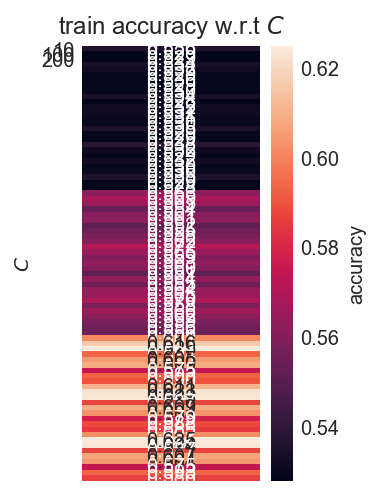

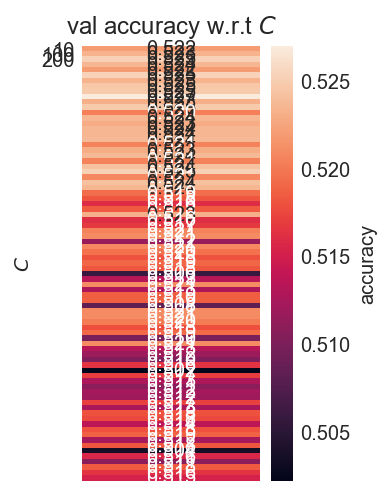

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.515)

###########################################################################

Decision Tree Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.492)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


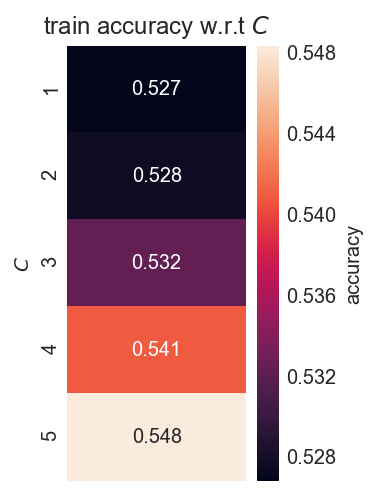

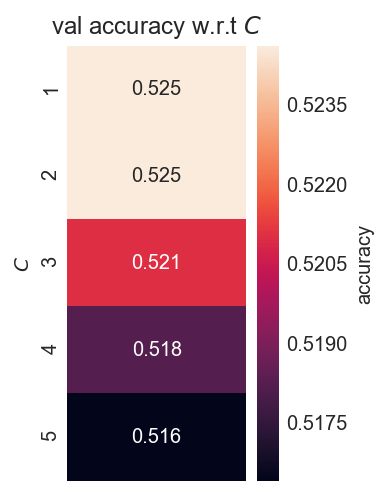

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.5146)

Trial #2
Adaboost Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.5606)
('Test Accuracy: ', 0.5068)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


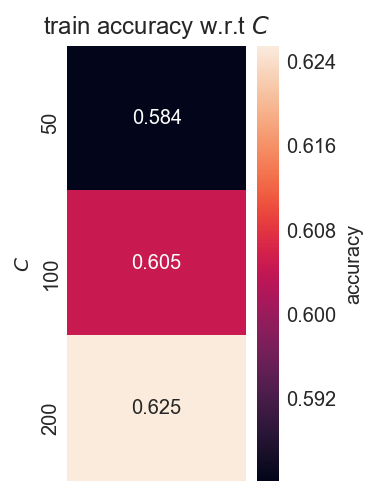

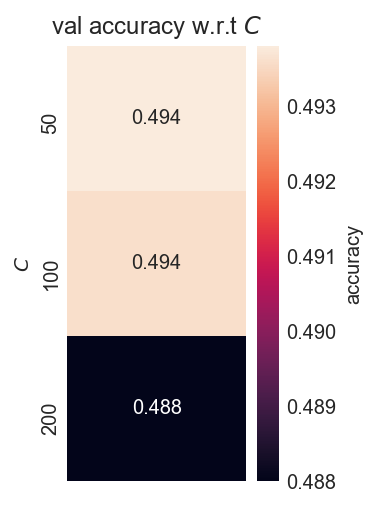

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.5068)

###########################################################################

Random Forest Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.9806)
('Test Accuracy: ', 0.4926)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


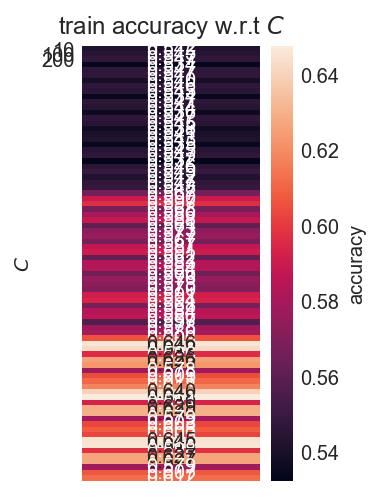

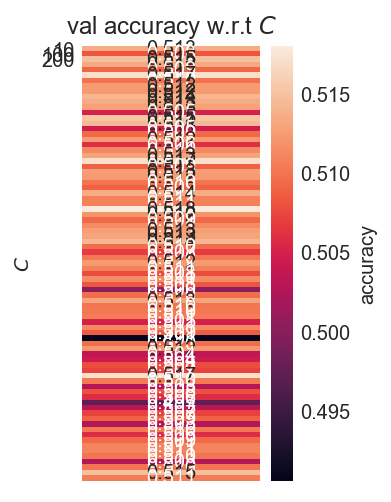

('Best number of estimators: ', 10)
('Best Max Depth: ', 4)
('Test Accuracy with best hyper-parameter: ', 0.5084)

###########################################################################

Decision Tree Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.4958)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


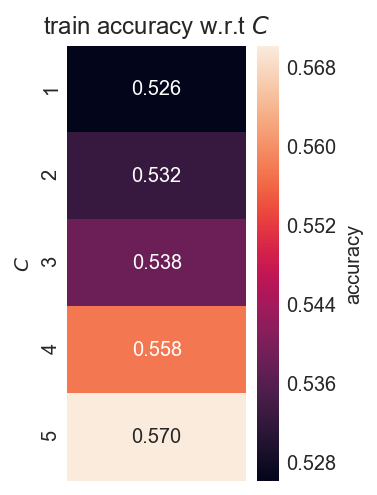

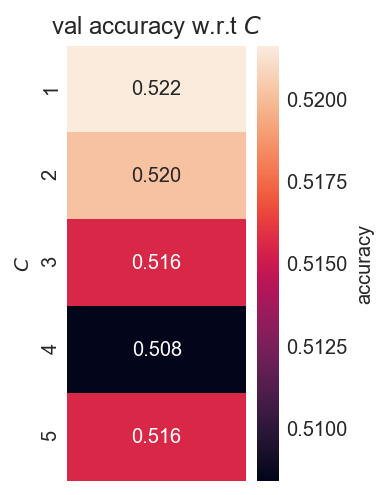

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.5034)

Trial #3
Adaboost Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.5814)
('Test Accuracy: ', 0.4976)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)


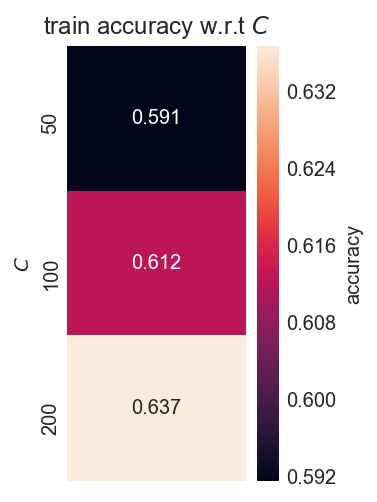

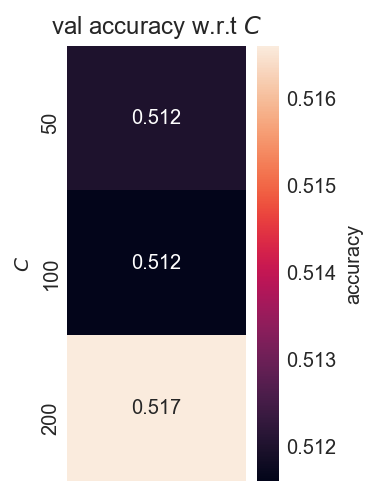

('Best number of estimators: ', 200)
('Test Accuracy with best hyper-parameter: ', 0.4972)

###########################################################################

Random Forest Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 0.9808)
('Test Accuracy: ', 0.5128)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


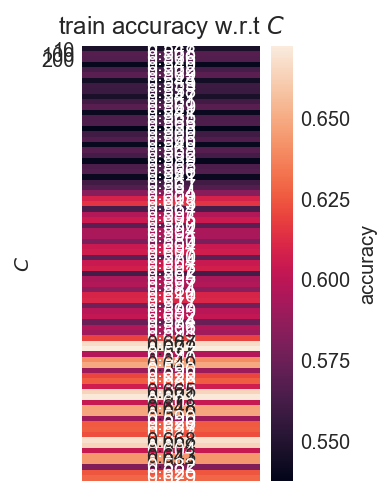

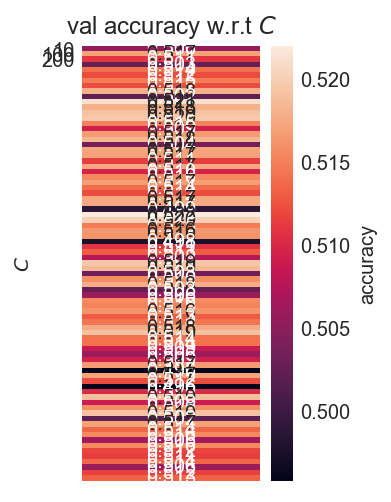

('Best number of estimators: ', 100)
('Best Max Depth: ', 4)
('Test Accuracy with best hyper-parameter: ', 0.499)

###########################################################################

Decision Tree Classifier
Split -- 0.500000 Training, 0.500000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.4814)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


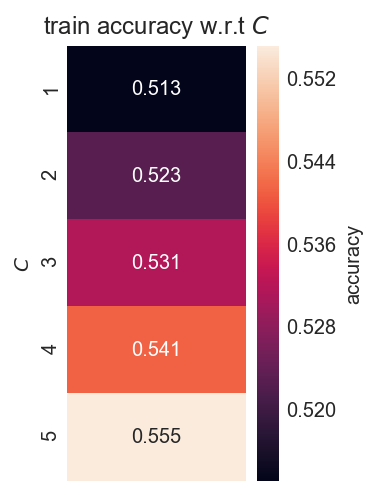

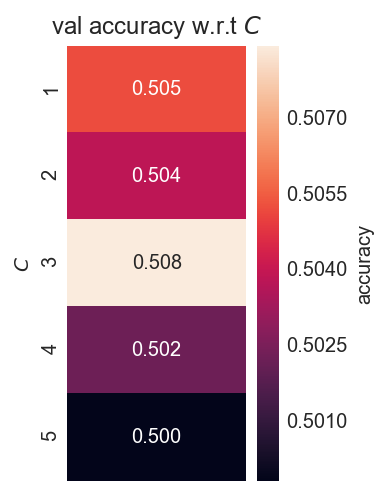

('Best Max_Depth: ', 3)
('Test Accuracy with best hyper-parameter(s): ', 0.5094)


In [29]:
#cell to call functions
print("covDF (50/50)")
print("----------------------------")
for num in range(0,3):
    
    print(("\nTrial #%d") % (num+1))
    adaBoost_avg,randForest_avg,DecisionTree_avg = covDF_classifer(covDF,.50,.50,
                                                                    adaBoost_avg,randForest_avg,DecisionTree_avg)

In [30]:
print(("Avg test error for Adaboost      (50/50): %f") % (float(adaBoost_avg / 3)))
print(("Avg test error for Random Forest (50/50): %f") % (float(randForest_avg / 3)))
print(("Avg test error for Decision Tree (50/50): %f") % (float(DecisionTree_avg / 3)))

#clear variables
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

Avg test error for Adaboost      (50/50): 0.504200
Avg test error for Random Forest (50/50): 0.507467
Avg test error for Decision Tree (50/50): 0.509133


covDF (20/80)
----------------------------

Trial #1
Adaboost Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.617)
('Test Accuracy: ', 0.491875)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)


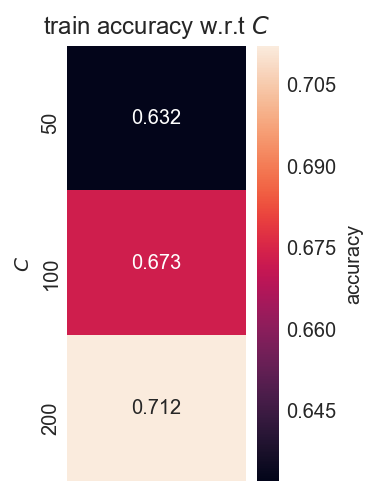

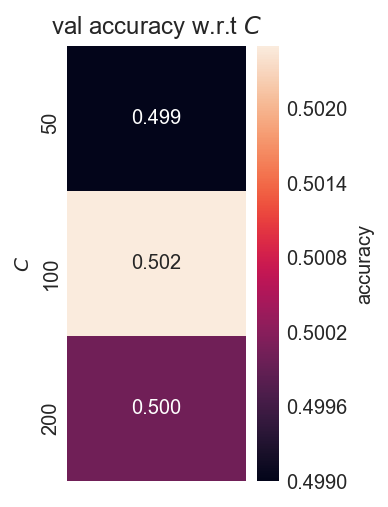

('Best number of estimators: ', 100)
('Test Accuracy with best hyper-parameter: ', 0.4935)

###########################################################################

Random Forest Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.9795)
('Test Accuracy: ', 0.50475)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


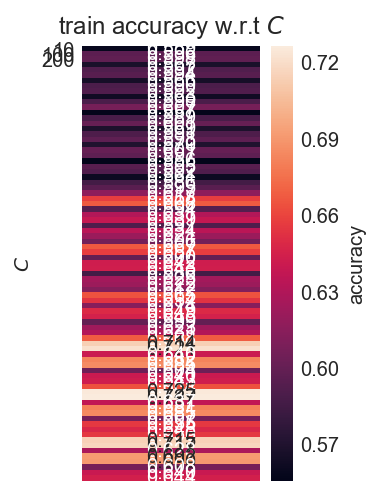

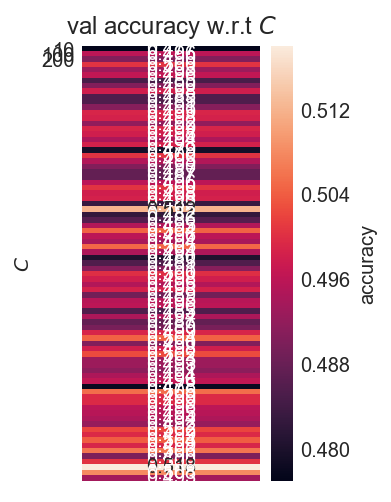

('Best number of estimators: ', 10)
('Best Max Depth: ', 6)
('Test Accuracy with best hyper-parameter: ', 0.49675)

###########################################################################

Decision Tree Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.49525)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


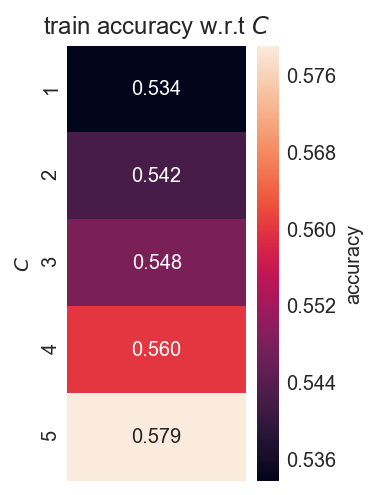

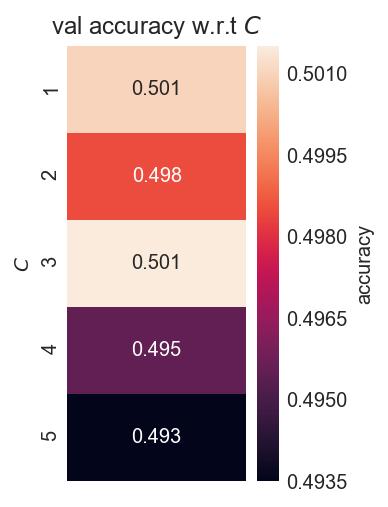

('Best Max_Depth: ', 3)
('Test Accuracy with best hyper-parameter(s): ', 0.505875)

Trial #2
Adaboost Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.6015)
('Test Accuracy: ', 0.509)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)


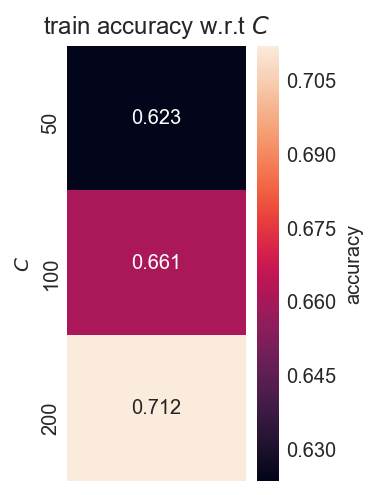

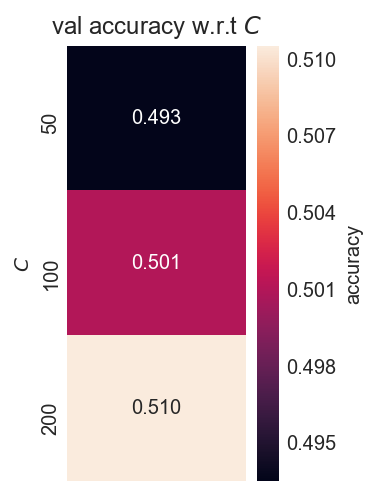

('Best number of estimators: ', 200)
('Test Accuracy with best hyper-parameter: ', 0.5045)

###########################################################################

Random Forest Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.983)
('Test Accuracy: ', 0.5105)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


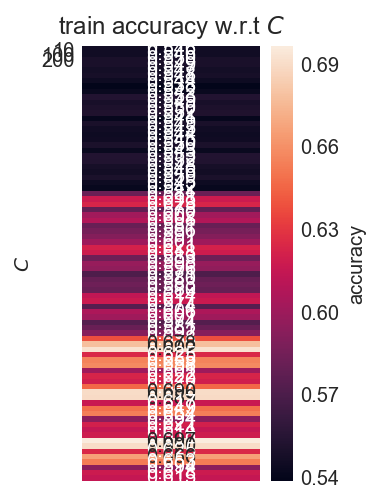

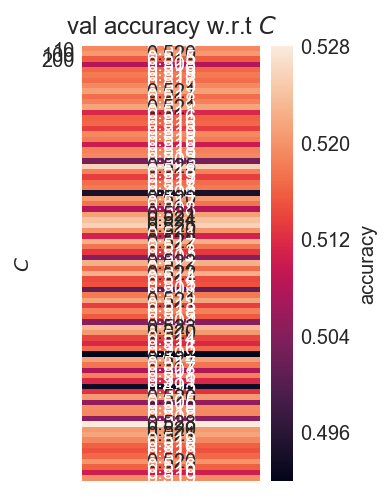

('Best number of estimators: ', 100)
('Best Max Depth: ', 6)
('Test Accuracy with best hyper-parameter: ', 0.516125)

###########################################################################

Decision Tree Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.512875)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


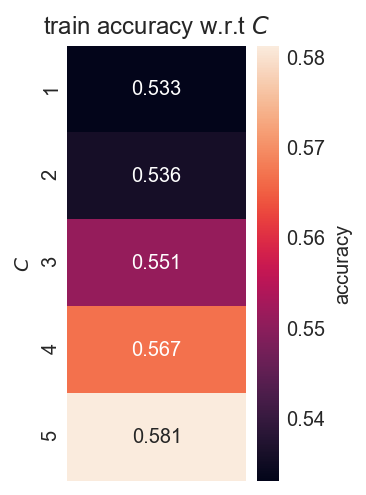

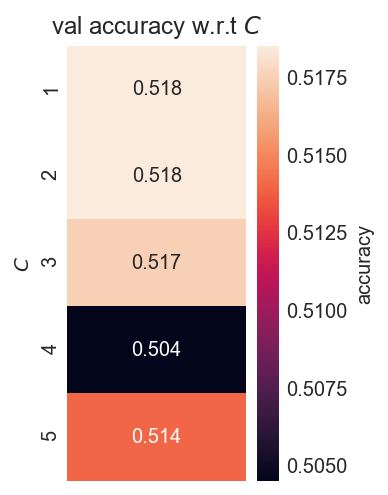

('Best Max_Depth: ', 1)
('Test Accuracy with best hyper-parameter(s): ', 0.514875)

Trial #3
Adaboost Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.631)
('Test Accuracy: ', 0.503625)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


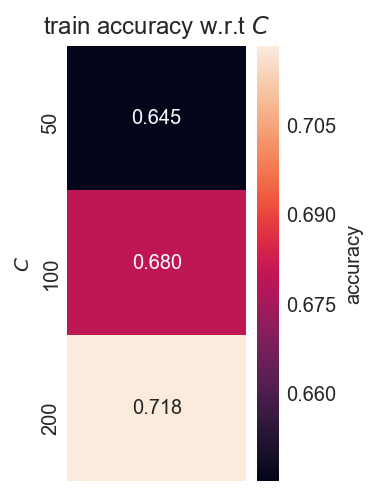

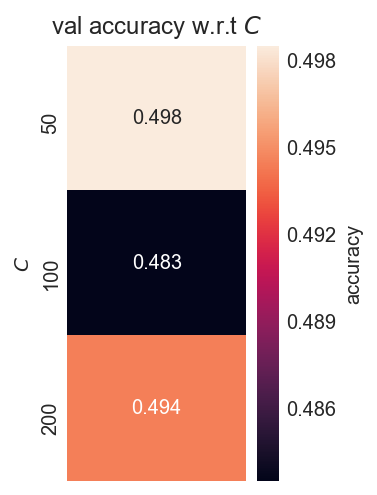

('Best number of estimators: ', 50)
('Test Accuracy with best hyper-parameter: ', 0.503625)

###########################################################################

Random Forest Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 0.9815)
('Test Accuracy: ', 0.5155)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


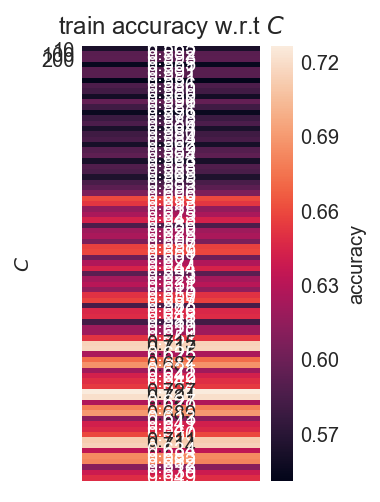

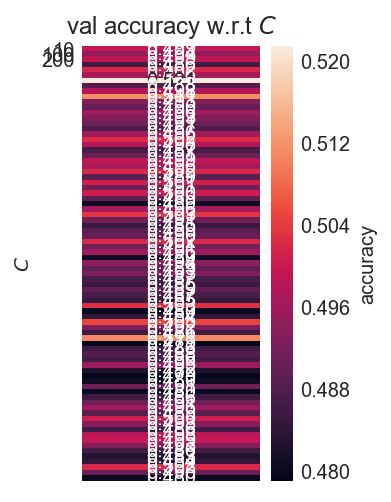

('Best number of estimators: ', 10)
('Best Max Depth: ', 2)
('Test Accuracy with best hyper-parameter: ', 0.510875)

###########################################################################

Decision Tree Classifier
Split -- 0.200000 Training, 0.800000 Testing
('Train Accuracy : ', 1.0)
('Test Accuracy: ', 0.495)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


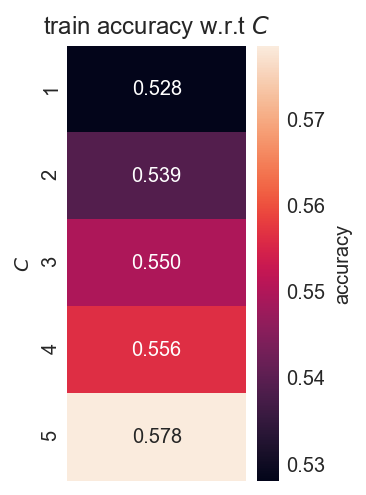

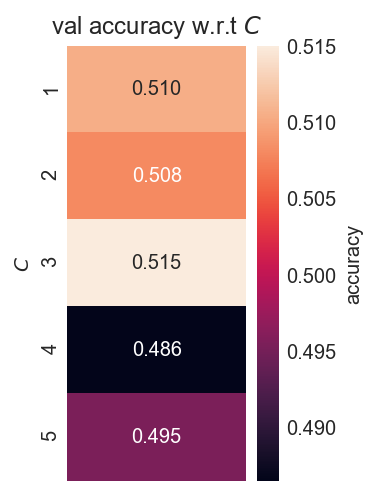

('Best Max_Depth: ', 3)
('Test Accuracy with best hyper-parameter(s): ', 0.502)


In [31]:
#cell to call functions
print("covDF (20/80)")
print("----------------------------")
for num in range(0,3):
    
    print(("\nTrial #%d") % (num+1))
    adaBoost_avg,randForest_avg,DecisionTree_avg = covDF_classifer(covDF,.20,.80,
                                                                    adaBoost_avg,randForest_avg,DecisionTree_avg)

In [32]:
print(("Avg test error for Adaboost      (20/80): %f") % (float(adaBoost_avg / 3)))
print(("Avg test error for Random Forest (20/80): %f") % (float(randForest_avg / 3)))
print(("Avg test error for Decision Tree (20/80): %f") % (float(DecisionTree_avg / 3)))

#clear variables
adaBoost_avg = 0
randForest_avg = 0
DecisionTree_avg = 0

Avg test error for Adaboost      (20/80): 0.500542
Avg test error for Random Forest (20/80): 0.507917
Avg test error for Decision Tree (20/80): 0.507583
